In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
import seaborn as sns

# Read in Data

In [2]:
train_df = pd.read_csv("data/train.csv")
song_df = pd.read_csv("data/songs.csv")

In [11]:
train_df.shape

(7377418, 6)

In [221]:
song_df.shape

(2296320, 7)

# EDA

In [3]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [5]:
train_df.nunique()

msno                   30755
song_id               359966
source_system_tab          8
source_screen_name        20
source_type               12
target                     2
dtype: int64

In [6]:
train_df.dtypes

msno                  object
song_id               object
source_system_tab     object
source_screen_name    object
source_type           object
target                 int64
dtype: object

In [573]:
print(f"Average target value: {train_df.target.mean()}")

Average target value: 0.5035170841614234


Above, we see that the dataset appears fairly balance with about half the observations being one where the user listened to the song again and half where the user did not.

## Missing values

In [7]:
train_df.isna().agg(["mean","sum"])

,msno,song_id,source_system_tab,source_screen_name,source_type,target
mean,0.0,0.0,0.003368,0.056226,0.00292,0.0
sum,0.0,0.0,24849.000000,414804.000000,21539.00000,0.0


In [143]:
train_df.isna()[["source_system_tab","source_screen_name","source_type"]].any(axis=1).mean()

0.05667579090679151

All missing values are in the `source_*` columns. Only 5% of the data has a missing value in one of the `source_*` columns. We can look at some imputation methods, but given how little data is missing, it might just be better to remove the observations.

### Distinct values for source columns

In [8]:
train_df.source_system_tab.value_counts()

source_system_tab
my library      3684730
discover        2179252
search           623286
radio            476701
listen with      212266
explore          167949
notification       6185
settings           2200
Name: count, dtype: int64

In [9]:
train_df.source_screen_name.value_counts()

source_screen_name
Local playlist more     3228202
Online playlist more    1294689
Radio                    474467
Album more               420156
Search                   298487
Artist more              252429
Discover Feature         244246
Discover Chart           213658
Others profile more      201795
Discover Genre            82202
My library                75980
Explore                   72342
Unknown                   54170
Discover New              15955
Search Trends             13632
Search Home               13482
My library_Search          6451
Self profile more           212
Concert                      47
Payment                      12
Name: count, dtype: int64

In [10]:
train_df.source_type.value_counts()

source_type
local-library             2261399
online-playlist           1967924
local-playlist            1079503
radio                      483109
album                      477344
top-hits-for-artist        423614
song                       244722
song-based-playlist        210527
listen-with                192842
topic-article-playlist      11194
artist                       3038
my-daily-playlist             663
Name: count, dtype: int64

All of these columns seem to have related values, how do they differ?

* `source_system_tab`: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab `my library` contains functions to manipulate the local storage, and tab `search` contains functions relating to search.
* `source_screen_name`: name of the layout a user sees.
* `source_type`: an entry point a user first plays music on mobile apps. An entry point could be `album`, `online-playlist`, `song` .. etc.

As the three columns are somewhat related, we should be able to impute the missing values fairly well by simply using the most common value given the other two columns. However, this is dependent on the other two columns not missing any data.

### Test imputing `source_screen_name` using `source_system_tab` and `source_type`

In [69]:
source_cols = ['source_system_tab', 'source_screen_name','source_type']

In [95]:
# Create dataframe with count of events for each combination of the source columns

grouped_source_cnt = train_df.groupby(
    ["source_system_tab","source_screen_name","source_type"], as_index=False
).msno.count().rename(columns={"msno":"cnt"}).sort_values("cnt", ascending=False)

grouped_source_cnt.head()

,source_system_tab,source_screen_name,source_type,cnt
222,my library,Local playlist more,local-library,2116268
223,my library,Local playlist more,local-playlist,1030707
62,discover,Online playlist more,online-playlist,1003188
337,radio,Radio,radio,462591
14,discover,Discover Chart,online-playlist,212747


In [157]:
# Get rows with no missing values
temp_df = train_df[~train_df.isna()[["source_system_tab","source_screen_name","source_type"]].any(axis=1)]

sample_size = 100000

# Using the `source_system_tab` and `source_type` columns, retrieve most common value for `source_screen_name`
temp_values = temp_df.iloc[:sample_size].apply(lambda x: grouped_source_cnt[
    (grouped_source_cnt[source_cols[0]]==x[source_cols[0]]) 
    & (grouped_source_cnt[source_cols[2]]==x[source_cols[2]])
].source_screen_name.iloc[0], axis=1)

# Calculate percent correct
np.equal(temp_values, temp_df.iloc[:sample_size].source_screen_name).mean()

0.89851

In [171]:
# Percent of observations with missing data in more than one column of all observations with mising data
np.mean(
    train_df[train_df.isna().any(axis=1)].isna()[source_cols].sum(axis=1) > 1
)

0.05947321469144099

We can get ~90% accuracy imputing `source_screen_name` using the remaining two.

Given that only 5% of all observations have missing data and there are over 7 million observations, the observations with missing data will just be dropped. But, this method for imputation can be useful if any test data or future data has missing values.  It is worth noting that it only works if two of the other columns are not missing data, however, only 5% of observations with missing data have data missing in multiple columns.

## Song counts by user

/opt/conda/envs/project/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 292'. Pick better value with 'binwidth'.


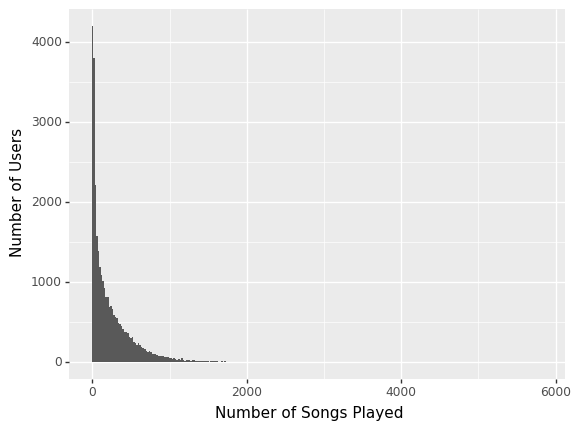

<ggplot: (8768918353429)>

In [453]:
# Histogram of number of songs by user
(p9.ggplot(data=train_df.groupby("msno")[["song_id"]].count(),
          mapping=p9.aes(x="song_id")) +
 p9.geom_histogram() +
 p9.labs(x="Number of Songs Played", y="Number of Users")
)

In [454]:
# Proportion of users that have listened to less than 5 songs
np.mean(train_df.groupby("msno").song_id.count() <= 5)

0.09725247927166314

Most users have listened to at least more than 5 songs. This can be helpful later, when looking at historical data for a user.

In [455]:
# Quantiles of number of songs per user
train_df.groupby("msno").song_id.count().quantile([0,0.25,0.5,0.75,1])

0.00       1.0
0.25      27.0
0.50     128.0
0.75     340.0
1.00    5819.0
Name: song_id, dtype: float64

Three quarters of all users have listened at least 27 songs.

### Percent of Songs Played Again by Total Number of Songs Played

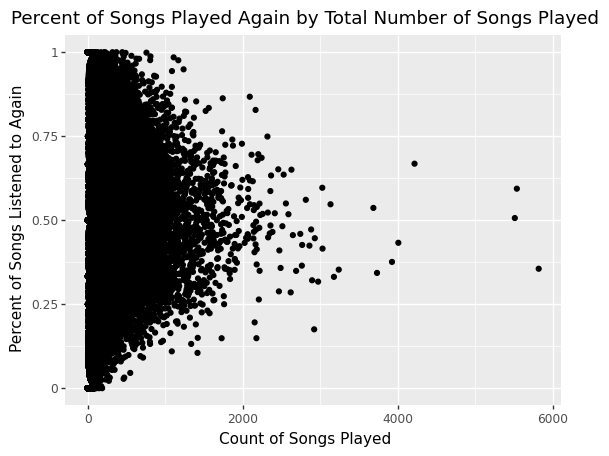

<ggplot: (8768909340813)>

In [456]:
# Number of songs and proportion played again
train_df.groupby("msno").agg({"song_id":"count", "target":"mean"})

# Scatterplot of number of songs and proportion played again

(p9.ggplot(data=train_df.groupby("msno").agg({"song_id":"count", "target":"mean"}),
          mapping=p9.aes(x="song_id", y="target")) +
p9.geom_point() +
 p9.labs(x="Count of Songs Played", y="Percent of Songs Listened to Again",
        title="Percent of Songs Played Again by Total Number of Songs Played")
)

It appears there's not much of a relationship between number of songs played and proportion played again.

## Source System Tab

In [457]:
source_tab_counts = train_df.groupby(
    ["source_system_tab","target"]
)[["song_id"]].count().reset_index()

source_tab_counts = source_tab_counts.rename(columns={"song_id":"target_count"})

source_tab_counts.head()

,source_system_tab,target,target_count
0,discover,0,1273185
1,discover,1,906067
2,explore,0,97050
3,explore,1,70899
4,listen with,0,142944


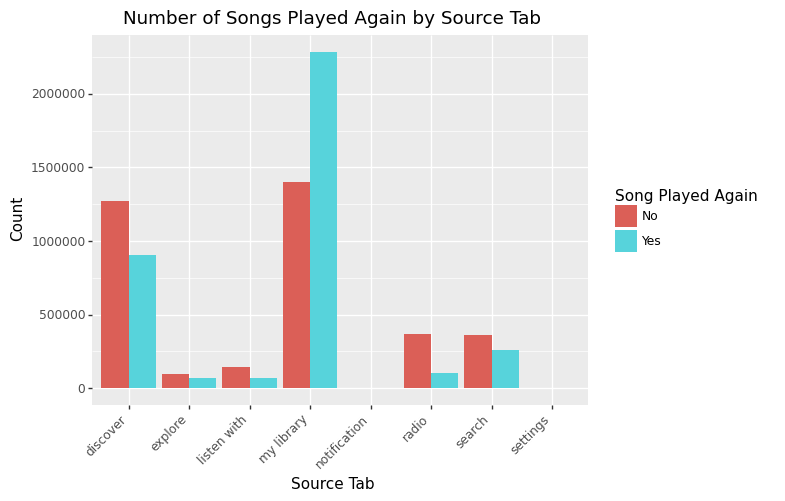

<ggplot: (8768918389269)>

In [458]:
(p9.ggplot(data=source_tab_counts,
         mapping=p9.aes(x="source_system_tab", y="target_count", fill="factor(target)")) +
 p9.geom_col(position='dodge') +
 p9.scale_fill_discrete(labels=['No', 'Yes'])+
 p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1)) +
 p9.labs(title="Number of Songs Played Again by Source Tab",
         x="Source Tab", y="Count", fill="Song Played Again")
)

## Source Screen Name

In [459]:
source_name_counts = train_df.groupby(
    ["source_screen_name","target"]
)[["song_id"]].count().reset_index()

source_name_counts = source_name_counts.rename(columns={"song_id":"target_count"})

source_name_counts.head()

,source_screen_name,target,target_count
0,Album more,0,256063
1,Album more,1,164093
2,Artist more,0,147202
3,Artist more,1,105227
4,Concert,0,23


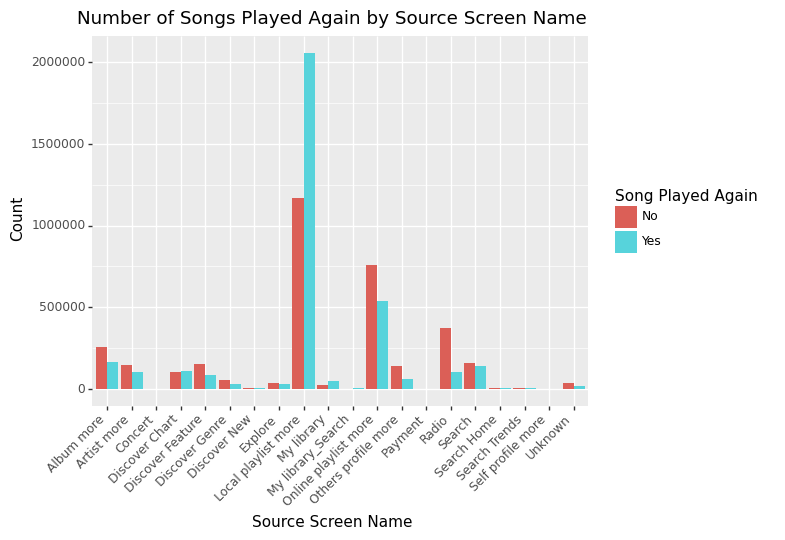

<ggplot: (8768899781021)>

In [460]:
(p9.ggplot(data=source_name_counts,
         mapping=p9.aes(x="source_screen_name", y="target_count", fill="factor(target)")) +
 p9.geom_col(position='dodge') +
 p9.scale_fill_discrete(labels=['No', 'Yes'])+
 p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1)) +
 p9.labs(title="Number of Songs Played Again by Source Screen Name",
         x="Source Screen Name", y="Count", fill="Song Played Again")
)

## Source Type

In [461]:
source_type_counts = train_df.groupby(
    ["source_type","target"]
)[["song_id"]].count().reset_index()

source_type_counts = source_type_counts.rename(columns={"song_id":"target_count"})

source_type_counts.head()

,source_type,target,target_count
0,album,0,289547
1,album,1,187797
2,artist,0,1298
3,artist,1,1740
4,listen-with,0,131200


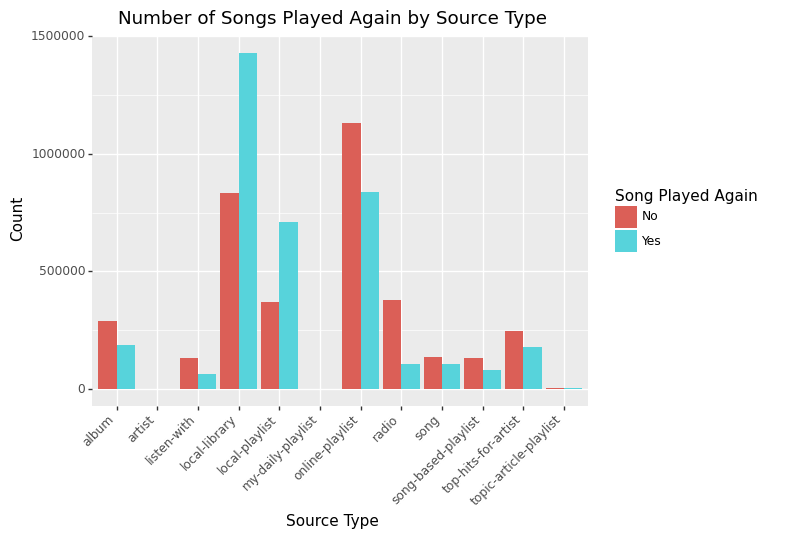

<ggplot: (8768917442217)>

In [462]:
(p9.ggplot(data=source_type_counts,
         mapping=p9.aes(x="source_type", y="target_count", fill="factor(target)")) +
 p9.geom_col(position='dodge') +
 p9.scale_fill_discrete(labels=['No', 'Yes'])+
 p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1)) +
 p9.labs(title="Number of Songs Played Again by Source Type",
         x="Source Type", y="Count", fill="Song Played Again")
)

This breakdown makes a lot of sense, where songs from local libraries and playlists are much more likely to be played again compared to online playlists or radios

## Song data

Using song data we can do a couple of things:
* Find the most common genres for a user
    * Identify which genres similar users listen to the most
    * Proportion of songs in each genre a user has listened to again
* Find the most common langauges by user

First, we will explore the song data; then, we will join it to the rest of the training data.

In [463]:
song_df.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [464]:
song_df.nunique()

song_id        2296320
song_length     146534
genre_ids         1045
artist_name     222363
composer        329822
lyricist        110924
language            10
dtype: int64

### Missing values

In [465]:
song_df.isna().agg(["mean","sum"])

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
mean,0.0,0.0,0.040986,0.0,4.665543e-01,8.471406e-01,0.0
sum,0.0,0.0,94116.000000,0.0,1.071358e+06,1.945306e+06,0.0


Some genres are missing but every song has a length and all but one have a language.

Below, is the song without a language and how many training observations include that song.

In [466]:
song_df[song_df.language.isna()]

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language


Looking at the composer, we see it says "Korea Lyrics by...," so we know the language is Korean, however, we don't know the language id. Below, we look for "Korean" in the composer field for other songs and see the top language ids.

In [467]:
song_df[song_df.composer.str.contains("Korean").fillna(False)].language.value_counts()

language
31.0    129
3.0      28
52.0      2
Name: count, dtype: int64

Most songs with "Korean" in the composer column have the language as 31, so we'll change the language to 31.

In [468]:
clean_song_df = song_df.copy()
clean_song_df.loc[605127,"language"]=31

In [469]:
clean_song_df.loc[[605127]]

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
605127,nMZ7IRARPBit0ZGegNfecsx77LQSpH2ZY93vyd5xRy0=,178654,444,JONGHYUN,Korean Lyrics by Kim| Jong Hyun / Lee| Yoon Se...,31,31.0


In [491]:
clean_song_df.to_parquet("data/clean_songs.paquet")

### Language column

In [470]:
# Distinct language values
clean_song_df.language.value_counts()

language
 52.0    1336694
-1.0      639467
 3.0      106295
 17.0      92518
 24.0      41744
 31.0      39202
 10.0      15482
 45.0      14435
 59.0       8098
 38.0       2385
Name: count, dtype: int64

I don't know what `-1` means for language, so let's take a look at what songs have `-1` for language below.

In [471]:
clean_song_df[song_df.language==-1]

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
12,fAZLdfQaLG76a6Ei4alt1eSjBM9rshQkiQEC6+n+y08=,180871,726,Littlesong,Michael William Balfe,NaN,-1.0
18,JcHIgDP5ivyqYIn7RxfXM13eWwOzcoxkWosSauz6RbU=,374027,726,White Noise,NaN,NaN,-1.0
28,+dOlHQGlsiHPbG1cMYsoFVsAi05YgsGfeEzsdS16yec=,368441,1609,Marvin Gaye & Kygo,Marvin Gaye| Odell Brown| David Ritz,Marvin Gaye| Odell Brown| David Ritz,-1.0
44,/pNJtPeT5RixL9cwAScQ83XG6lzNjQbxXdz9Bxm3UCk=,954851,873,蘇曼竹巴仁波切,公版,公版,-1.0
54,vLLKr+iN+vepbTD6W2kDXHvuqmGiXGdXRRHLjRp0pCQ=,300257,873,原力歌手,王苒馨,公版,-1.0
...,...,...,...,...,...,...,...
2296301,HpAyT/rz9ta5hku/j/COjmjVXY0XNFjsMnT454rbfqU=,255922,388,Yin Yoga Academy,Sacchetto G.,NaN,-1.0
2296304,drhKIG4cRzpkiJaW0gem3MpKBNAHziSggBiiMjyZzWE=,263836,958,Felix Mendelssohn,NaN,NaN,-1.0
2296306,b2TN2bI6sO05QpFYHY2AtwYr1wIxQ4FilfOqdzyHXWg=,153716,2122,Michael Silverman Jazz Piano Trio,NaN,NaN,-1.0
2296310,UcUZh2+hem1XsHnDdkYSAiWmZmD2eVtA5e0SK/FUCGs=,60081,958,Orgel Carrol 오르골캐롤,NaN,NaN,-1.0


It appears that `-1` means there are no lyrics and thus no language. So this should be a problem.

### Genre column

In [472]:
song_genre = clean_song_df.set_index("song_id").genre_ids.str.split("|").explode().reset_index()

In [473]:
song_genre.head()

,song_id,genre_ids
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,465
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,444
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,465
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,465
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,726


In [474]:
song_genre.genre_ids.nunique()

191

In [475]:
song_genre.genre_ids.unique()

array(['465', '444', '726', '864', '857', '850', '843', '458', '352',
       '1995', '2157', '359', '1609', '139', nan, '873', '1955', '1011',
       '2022', '2122', '786', '947', '242', '1259', '921', '2107', '958',
       '880', '481', '125', '109', '798', '451', '1152', '940', '1082',
       '545', '437', '829', '430', '1969', '388', '94', '1572', '275',
       '409', '893', '1616', '712', '2130', '2086', '374', '1568', '1138',
       '474', '1180', '1068', '423', '184', '744', '691', '2189', '367',
       '719', '2072', '1977', '402', '1287', '2079', '822', '2058',
       '1155', '1633', '310', '900', '191', '2109', '1280', '2093',
       '1630', '118', '663', '1208', '2100', '1944', '1103', '381', '331',
       '1096', '509', '1040', '1047', '1981', '698', '516', '907', '102',
       '1598', '2032', '1273', '1145', '212', '972', '2213', '1026',
       '1110', '177', '2215', '205', '986', '2144', '2176', '1605',
       '1019', '95', '1054', '2248', '1162', '965', '198', '531', '198

Everything seems to look good with the genre ids.

### Song Length

In [476]:
clean_song_df.song_length.nunique()

146534

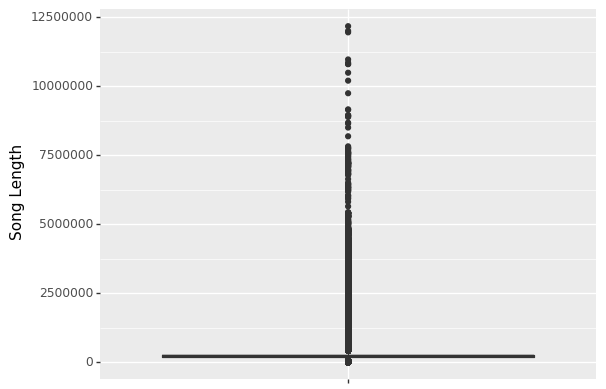

<ggplot: (8768849055817)>

In [477]:
# Boxplot of `song_length`
(
    p9.ggplot(data=clean_song_df) +
    p9.geom_boxplot(p9.aes(x="''", y="song_length")) +
    p9.labs(x="", y="Song Length")
)

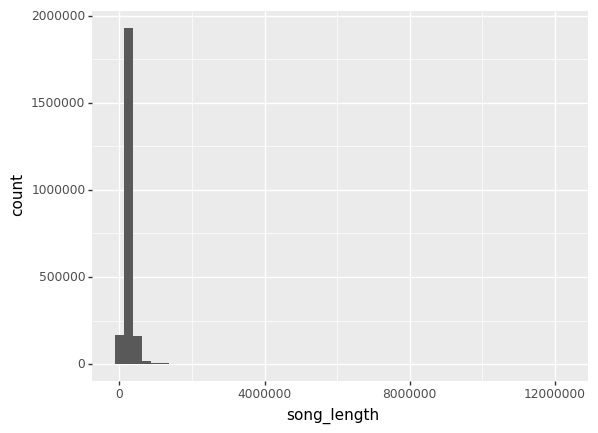

<ggplot: (8742743097441)>

In [50]:
# Histogram of `song_length`
(
    p9.ggplot(data=clean_song_df,
          mapping=p9.aes(x="song_length")) +
    p9.geom_histogram(bins=50)
)

As you might expect with song length, most are within a normal, reasonable range, but there are some very extreme songs. These might be podcasts, audiobooks, or just weird songs. Let's take a look below.

In [479]:
clean_song_df[clean_song_df.song_length>= 2500000].language.value_counts()

language
-1.0     984
 52.0    552
 3.0      14
 38.0      2
 31.0      1
 17.0      1
Name: count, dtype: int64

A significant portion are instrumental songs, which makes sense. Let's exclude those songs and look at the remaining ones.

In [480]:
clean_song_df[(clean_song_df.song_length >= 2500000) & (clean_song_df.language!=-1)]

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
5149,UEjh6tuLXUPY24Ch9GNwgIwsLg6t22rp5rMLi8aQcYE=,4025318,1609,Various Artists,NaN,NaN,52.0
27009,w3paK86tdZBDBfQxjpO2MpZQlzZEtGZa8KVNhlAHdeE=,4613433,1609,Deep Dish,NaN,NaN,52.0
43876,RP0HLRDeLfsK83aZTFvKJSVWqdMGkPz004VZN8ElhI0=,2863856,1609,Various Artists,NaN,NaN,52.0
58891,lIYSX0SGAO22CvSDMfjFoKA49ifhQ+QA+SgL6MLEXZ0=,3377920,1609,David Guetta,David Guetta,NaN,52.0
63048,KXn+127Sc1ZRwWqfMJoqWFSy9tLIOuH2/ajjlSYsJVo=,5402017,NaN,Sound Dreamer,NaN,NaN,52.0
...,...,...,...,...,...,...,...
2265534,/yfigSqdNp0Oz0kXCeuayU/JmOS8orR5O3sTTjbzEAI=,3606801,388,End of the World,End of the World,NaN,52.0
2273423,BV/b95mc07VxPab0ElY51DjBpitHxC2S3Tlttfkl9Z8=,4752288,1609,Various Artists,NaN,NaN,52.0
2283981,pNRHwplmlP4OlvToSUZnomxAI+A2NtRXORakRN8n68o=,2707644,1609,Various Artists,NaN,NaN,52.0
2289921,wPjHepG4ZFRud+aHeKddoXg98EOGvyuCkeKDbG04UHo=,2514256,1609,Various Artists,NaN,NaN,52.0


In [481]:
clean_song_df[
    (clean_song_df.song_length >= 2500000) & (clean_song_df.language!=-1)
].genre_ids.str.split("|").explode().value_counts().head()

genre_ids
1609    242
465     141
388      36
1616     21
940      20
Name: count, dtype: int64

It appears that a lot of these songs are DJ mixes which would include multiple songs mixed together, which might explain the long runtime. Looking at the genre ids, they all mostly appear to be the same genre, which supports this claim. The other genre seems to be jazz, which also makes sense with a long length.

### Join song data to training data

In [482]:
merged_train_df = train_df.merge(clean_song_df[["song_id","song_length","language"]], on="song_id")
merged_genre_train_df = merged_train_df.merge(song_genre, on="song_id")
merged_genre_train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,language,genre_ids
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471,52.0,359
1,e5Ezre9HPuPos+CXQXtmo32E/hHIZTMmo6jG3yRf6UA=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-playlist,1,206471,52.0,359
2,pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,online-playlist,0,206471,52.0,359
3,sSexP400TJOZRhx3JB+0s9cqrCnqrlV51B9njoKR1II=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,online-playlist,0,206471,52.0,359
4,hKdGiUKHVqKkXGHLrc+EzdSW6q0ERAJ2Cs7/L1N0Ae4=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,NaN,online-playlist,0,206471,52.0,359


In [483]:
# Count of events without a song match
train_df.merge(
    clean_song_df[["song_id","song_length","language"]], on="song_id", how="left"
).song_length.isna().sum()

114

*Note:* There are 106 events that do not have a matching song in the song database.

### Proportion of long songs played again

In [396]:
merged_train_df[merged_train_df.song_length>=1000000].target.mean()

0.3772669220945083

In [397]:
merged_train_df[merged_train_df.song_length>=1000000].shape

(3915, 8)

It seems that longer songs are, on average, not played again. However, compared to the size of the dataset, this is a small sample and may not be completely accurate. This might also make sense because a user may not want to listen to the same long mix again after listening to it once.

### Top genres by user

For top genres by user, a simple first approach is to use the percent of songs a user has listened to from a given genre. But first, we should find out if a user-song combination only appears once in the data or if there is data on how many times a user has listened to a song.

In [344]:
# Check if a user can have the same song multiple times
train_df.groupby(["msno", "song_id"]).count().target.max()

1

Based, on the cell above, it appears that we only have unique songs by user and whether they have listened to it at least one more time. So, we only know if a user has listened to a song once, twice, or not at all. Therefore, when calculating a relevancy score, we should count songs played again as two instead of one.

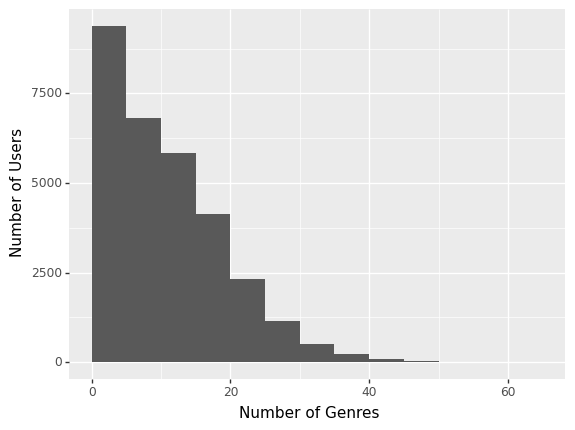

<ggplot: (8768920131029)>

In [433]:
# Histogram of number of genres per user
(
    p9.ggplot(data=merged_genre_train_df.groupby("msno").genre_ids.nunique().reset_index(),
             mapping=p9.aes(x="genre_ids")) +
    p9.geom_histogram(binwidth=5, boundary=0) +
    p9.labs(x="Number of Genres", y="Number of Users")
)

From the histogram above, it seems that most users only listen to a handful of genres. This, again, is in line with what you might already assume.

In [432]:
# Count of songs for each genre by user
user_genre_df = merged_genre_train_df.groupby(
    ["msno","genre_ids"]
).agg({"song_id":"count", "target":"sum"}).rename(
    columns={"song_id":"song_count", "target":"count_listened_again"}
)

user_genre_df["total_song_count"] = \
    user_genre_df.song_count + user_genre_df.count_listened_again

user_genre_df["proportion_listened_again"] = \
    user_genre_df.count_listened_again / user_genre_df.song_count

# Calculate percent of songs in each genre by user
user_genre_df["genre_percent"] = user_genre_df.total_song_count / \
    user_genre_df.groupby("msno").total_song_count.transform("sum")

user_genre_df.head(12)

song_count   
msno                                         genre_ids               
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259               45  \
                                             139                 3   
                                             1609               13   
                                             1616                9   
                                             2022               13   
                                             359                17   
                                             451                12   
                                             458                72   
                                             465               195   
                                             474                36   
                                             726                 1   
                                             921                10   

                                                        count_listened_again   
msno                                         genre_ids                         
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259                         27  \
                                             139                           3   
                                             1609                          9   
                                             1616                          0   
                                             2022                          3   
                                             359                          10   
                                             451                           5   
                                             458                          39   
                                             465                         105   
                                             474                          12   
                                             726                           0   
                                             921                           4   

                                                        total_song_count   
msno                                         genre_ids                     
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259                     72  \
                                             139                       6   
                                             1609                     22   
                                             1616                      9   
                                             2022                     16   
                                             359                      27   
                                             451                      17   
                                             458                     111   
                                             465                     300   
                                             474                      48   
                                             726                       1   
                                             921                      14   

                                                        proportion_listened_again   
msno                                         genre_ids                              
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259                        0.600000  \
                                             139                         1.000000   
                                             1609                        0.692308   
                                             1616                        0.000000   
                                             2022                        0.230769   
                                             359                         0.588235   
                                             451                         0.416667   
                                             458                         0.541667   
                                       

*Note:* For the above user, there is a genre where teh user has listened to every song again, but has not listened to many songs in that genre. We did somewhat account for this by adding songs listened to again when calculating `total_song_count`, but if we use both `proportion_listened_again` and `genre_percent` in a model, we should ensure `proportion_listened_again` is not over weighted.

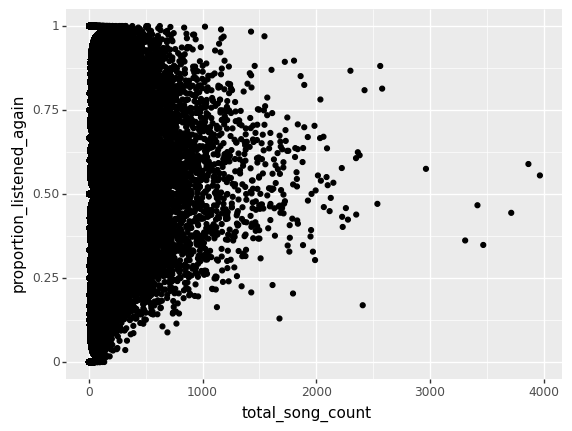

<ggplot: (8768809434457)>

In [503]:
(
    p9.ggplot(data=user_genre_df,
             mapping=p9.aes(x="total_song_count",
                           y="proportion_listened_again")
             ) +
    p9.geom_point()
)

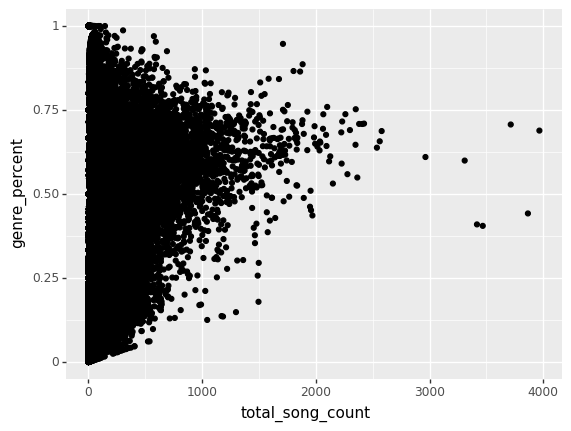

<ggplot: (8768809457985)>

In [504]:
(
    p9.ggplot(data=user_genre_df,
             mapping=p9.aes(x="total_song_count",
                           y="genre_percent")
             ) +
    p9.geom_point()
)

In [449]:
# Save genre relevancy to parquet
user_genre_df.to_parquet("data/user_genre_rlcy.parquet")

### Top languages by user

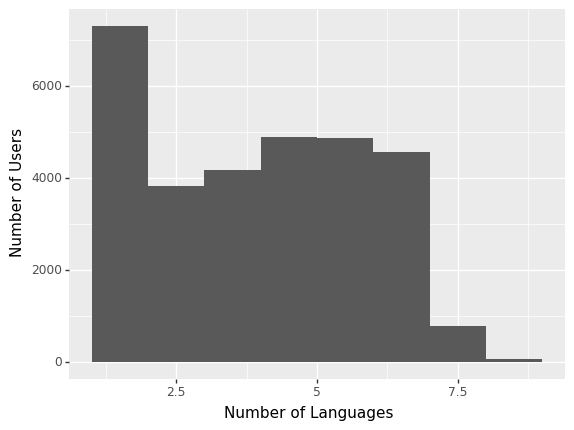

<ggplot: (8768919386437)>

In [437]:
# Histogram of number of languages per user
(
    p9.ggplot(data=merged_genre_train_df.groupby("msno").language.nunique().reset_index(),
             mapping=p9.aes(x="language")) +
    p9.geom_histogram(binwidth=1, boundary=0) +
    p9.labs(x="Number of Languages", y="Number of Users")
)

Most users only listen to one language, but there is another peak around 5 languages.

In [438]:
# Count of songs for each language by user
user_language_df = merged_train_df.groupby(
    ["msno","language"]
).agg({"song_id":"count", "target":"sum"}).rename(
    columns={"song_id":"song_count", "target":"count_listened_again"}
)

user_language_df["total_song_count"] = \
    user_language_df.song_count + user_language_df.count_listened_again

user_language_df["proportion_listened_again"] = \
    user_language_df.count_listened_again / user_language_df.song_count

# Calculate percent of songs in each language by user
user_language_df["language_percent"] = user_language_df.total_song_count / \
    user_language_df.groupby("msno").total_song_count.transform("sum")

user_language_df.head(12)

song_count   
msno                                         language               
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= -1.0              41  \
                                              3.0             243   
                                              10.0              1   
                                              17.0              2   
                                              24.0              6   
                                              52.0            130   
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=  3.0              96   
                                              31.0             36   
                                              52.0             74   
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=  3.0              98   
                                              24.0              5   
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=  3.0              12   

                                                       count_listened_again   
msno                                         language                         
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= -1.0                        13  \
                                              3.0                       140   
                                              10.0                        0   
                                              17.0                        0   
                                              24.0                        1   
                                              52.0                       60   
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=  3.0                        70   
                                              31.0                       18   
                                              52.0                       42   
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=  3.0                        70   
                                              24.0                        3   
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=  3.0                         1   

                                                       total_song_count   
msno                                         language                     
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= -1.0                    54  \
                                              3.0                   383   
                                              10.0                    1   
                                              17.0                    2   
                                              24.0                    7   
                                              52.0                  190   
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=  3.0                   166   
                                              31.0                   54   
                                              52.0                  116   
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=  3.0                   168   
                                              24.0                    8   
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=  3.0                    13   

                                                       proportion_listened_again   
msno                                         language                              
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= -1.0                       0.317073  \
                                              3.0                       0.576132   
                                              10.0                      0.000000   
                                              17.0                      0.000000   
                                              24.0                      0.166667   
                                              52.0                      0.461538   
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=  3.0                       0.729167   
                                              31.0                      0.500000   
                                              52.0                      0.567568   
++e+js

In [450]:
# Save language relevancy to parquet
user_language_df.to_parquet("data/user_language_rlcy.parquet")

### Top genre-language combinations by user

In [442]:
# Count of songs for each genre by user
user_language_genre_df = merged_genre_train_df.groupby(
    ["msno","genre_ids","language"]
).agg({"song_id":"count", "target":"sum"}).rename(
    columns={"song_id":"song_count", "target":"count_listened_again"}
)

user_language_genre_df["total_song_count"] = \
    user_language_genre_df.song_count + user_language_genre_df.count_listened_again

user_language_genre_df["proportion_listened_again"] = \
    user_language_genre_df.count_listened_again / user_language_genre_df.song_count

# Calculate percent of songs in each genre by user
user_language_genre_df["genre_language_percent"] = user_language_genre_df.total_song_count / \
    user_language_genre_df.groupby("msno").total_song_count.transform("sum")

user_language_genre_df.head(22)

song_count   
msno                                         genre_ids language               
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259      -1.0               4  \
                                                        3.0              19   
                                                        52.0             22   
                                             139        52.0              3   
                                             1609      -1.0               1   
                                                        52.0             12   
                                             1616       52.0              9   
                                             2022       17.0              1   
                                                        52.0             12   
                                             359        52.0             17   
                                             451        3.0               6   
                                                        24.0              6   
                                             458        3.0              72   
                                             465        3.0             144   
                                                        10.0              1   
                                                        17.0              1   
                                                        52.0             49   
                                             474       -1.0              36   
                                             726        52.0              1   
                                             921        3.0               6   
                                                        52.0              4   
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg= 1011       52.0              3   

                                                                 count_listened_again   
msno                                         genre_ids language                         
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259      -1.0                         0  \
                                                        3.0                        18   
                                                        52.0                        9   
                                             139        52.0                        3   
                                             1609      -1.0                         1   
                                                        52.0                        8   
                                             1616       52.0                        0   
                                             2022       17.0                        0   
                                                        52.0                        3   
                                             359        52.0                       10   
                                             451        3.0                         4   
                                                        24.0                        1   
                                             458        3.0                        39   
                                             465        3.0                        79   
                                                        10.0                        0   
                                                        17.0                        0   
                                                        52.0                       26   
                                             474       -1.0                        12   
                                             726        52.0                        0   
                                             921        3.0                         3   
                                                        52.0                        1   
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg= 1011       52.0                        2   

                               

In [451]:
# Save genre-language mapping to parquet
user_language_genre_df.to_parquet("data/user_genre_language_combinations.parquet")

# Preprocess song data

From the user-genre, user-language, user-genre-language relevancy scores generated above, we will now generate the features for each observation in the training data and remove observations with missing values.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
import seaborn as sns

## Read in data

In [5]:
train_df = pd.read_csv("data/train.csv")
clean_song_df = pd.read_parquet("data/clean_songs.paquet")
user_genre_df = pd.read_parquet("data/user_genre_rlcy.parquet")
user_language_df = pd.read_parquet("data/user_language_rlcy.parquet")
user_genre_language_df = pd.read_parquet("data/user_genre_language_combinations.parquet")

## Merge data

In [9]:
source_cols = ['source_system_tab', 'source_screen_name','source_type']

# Remove observations with missing data in `source_*` columns
clean_train_df = train_df.dropna(subset=source_cols)
print(clean_train_df.shape[0] / train_df.shape[0])
clean_train_df.head()

0.9433242090932085


,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [10]:
song_genre = clean_song_df.set_index("song_id").genre_ids.str.split("|").explode().reset_index()

# Doesn't include genre
clean_merged_train_df = clean_train_df.merge(
    clean_song_df[["song_id","song_length","language"]], on="song_id"
)
# Includes unnest genres -> duplicate observations for a song with multiple genres
clean_merged_genre_train_df = clean_merged_train_df.merge(song_genre, on="song_id")
clean_merged_genre_train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,language,genre_ids
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471,52.0,359
1,e5Ezre9HPuPos+CXQXtmo32E/hHIZTMmo6jG3yRf6UA=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-playlist,1,206471,52.0,359
2,pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,online-playlist,0,206471,52.0,359
3,sSexP400TJOZRhx3JB+0s9cqrCnqrlV51B9njoKR1II=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,online-playlist,0,206471,52.0,359
4,/MH2JxNx5K+YTZP/boA9q+CDtJbDPuwVm23EtkDk6sA=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,0,206471,52.0,359


## Generate genre scores

In [11]:
user_genre_df.head()

song_count   
msno                                         genre_ids               
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259               45  \
                                             139                 3   
                                             1609               13   
                                             1616                9   
                                             2022               13   

                                                        count_listened_again   
msno                                         genre_ids                         
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259                         27  \
                                             139                           3   
                                             1609                          9   
                                             1616                          0   
                                             2022                          3   

                                                        total_song_count   
msno                                         genre_ids                     
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259                     72  \
                                             139                       6   
                                             1609                     22   
                                             1616                      9   
                                             2022                     16   

                                                        proportion_listened_again   
msno                                         genre_ids                              
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259                        0.600000  \
                                             139                         1.000000   
                                             1609                        0.692308   
                                             1616                        0.000000   
                                             2022                        0.230769   

                                                        genre_percent  
msno                                         genre_ids                 
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259            0.111975  
                                             139             0.009331  
                                             1609            0.034215  
                                             1616            0.013997  
                                             2022            0.024883

In [12]:
# Merge genre features into train set
genre_scores_df = clean_merged_genre_train_df.set_index(
    ["msno","genre_ids"]
).merge(user_genre_df, left_index=True, right_index=True)

# Reset index, select relevant features and rename them
genre_scores_df = genre_scores_df.reset_index()[
    ["msno","genre_ids","song_id","total_song_count","proportion_listened_again","genre_percent"]
].rename(columns={"total_song_count": "genre_song_count",
                 "proportion_listened_again": "genre_listened_again_percent"})

# Group by user, song_id then select the genre with the most number of songs
genre_scores_df = genre_scores_df.set_index(
    ["msno", "song_id", "genre_ids"]
).sort_values("genre_song_count", ascending=False)\
.groupby(["msno", "song_id"]).first()

genre_scores_df.head()

genre_song_count   
msno                                         song_id                                                          
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +/lcxtBy9FuH0ObLsK9wRf3zl9zSyvDNMpTWSGCAXxc=                48  \
                                             +JGuj3rm4FBs8loN7rvI+JZ+EX3K9+WaxbDtmjs6mQc=               300   
                                             +MRnGH0Gg7jA7izLFRU1SZtGPmWHdsWTeL9wRXChnRA=               300   
                                             +Sm75wnBf/sjm/QMUAFx8N+Ae04kWCXGlgH50tTeM6c=               300   
                                             +d62ngXhdNTJRLKXO8/X9+BBoj77Hs8xVHMLmYGmB4k=               300   

                                                                                           genre_listened_again_percent   
msno                                         song_id                                                                      
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +/lcxtBy9FuH0ObLsK9wRf3zl9zSyvDNMpTWSGCAXxc=                      0.333333  \
                                             +JGuj3rm4FBs8loN7rvI+JZ+EX3K9+WaxbDtmjs6mQc=                      0.538462   
                                             +MRnGH0Gg7jA7izLFRU1SZtGPmWHdsWTeL9wRXChnRA=                      0.538462   
                                             +Sm75wnBf/sjm/QMUAFx8N+Ae04kWCXGlgH50tTeM6c=                      0.538462   
                                             +d62ngXhdNTJRLKXO8/X9+BBoj77Hs8xVHMLmYGmB4k=                      0.538462   

                                                                                           genre_percent  
msno                                         song_id                                                      
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +/lcxtBy9FuH0ObLsK9wRf3zl9zSyvDNMpTWSGCAXxc=       0.074650  
                                             +JGuj3rm4FBs8loN7rvI+JZ+EX3K9+WaxbDtmjs6mQc=       0.466563  
                                             +MRnGH0Gg7jA7izLFRU1SZtGPmWHdsWTeL9wRXChnRA=       0.466563  
                                             +Sm75wnBf/sjm/QMUAFx8N+Ae04kWCXGlgH50tTeM6c=       0.466563  
                                             +d62ngXhdNTJRLKXO8/X9+BBoj77Hs8xVHMLmYGmB4k=       0.466563

In [13]:
# Number of observations without genre information
clean_merged_train_df.shape[0] - genre_scores_df.shape[0]

111944

In [14]:
# Percent of observations without genre information
(clean_merged_train_df.shape[0] - genre_scores_df.shape[0])\
/ clean_merged_train_df.shape[0]

0.0160857777865272

## Generate language scores

In [15]:
user_language_df.head()

song_count   
msno                                         language               
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= -1.0              41  \
                                              3.0             243   
                                              10.0              1   
                                              17.0              2   
                                              24.0              6   

                                                       count_listened_again   
msno                                         language                         
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= -1.0                        13  \
                                              3.0                       140   
                                              10.0                        0   
                                              17.0                        0   
                                              24.0                        1   

                                                       total_song_count   
msno                                         language                     
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= -1.0                    54  \
                                              3.0                   383   
                                              10.0                    1   
                                              17.0                    2   
                                              24.0                    7   

                                                       proportion_listened_again   
msno                                         language                              
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= -1.0                       0.317073  \
                                              3.0                       0.576132   
                                              10.0                      0.000000   
                                              17.0                      0.000000   
                                              24.0                      0.166667   

                                                       language_percent  
msno                                         language                    
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= -1.0              0.084772  
                                              3.0              0.601256  
                                              10.0             0.001570  
                                              17.0             0.003140  
                                              24.0             0.010989

In [16]:
# Merge language features into train set
language_scores_df = clean_merged_train_df.set_index(
    ["msno","language"]
).merge(user_language_df, left_index=True, right_index=True)

# Reset index, select relevant features and rename them
language_scores_df = language_scores_df.reset_index()[
    ["msno","language","song_id","total_song_count","proportion_listened_again","language_percent"]
].rename(columns={"total_song_count": "language_song_count",
                 "proportion_listened_again": "language_listened_again_percent"})

# Group by user, song_id then select the language with the most number of songs
language_scores_df = language_scores_df.set_index(
    ["msno", "song_id", "language"]
).sort_values("language_song_count", ascending=False)\
.groupby(["msno", "song_id"]).first()

language_scores_df.head()

language_song_count   
msno                                         song_id                                                             
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +/lcxtBy9FuH0ObLsK9wRf3zl9zSyvDNMpTWSGCAXxc=                   54  \
                                             +JGuj3rm4FBs8loN7rvI+JZ+EX3K9+WaxbDtmjs6mQc=                  383   
                                             +MRnGH0Gg7jA7izLFRU1SZtGPmWHdsWTeL9wRXChnRA=                  383   
                                             +Sm75wnBf/sjm/QMUAFx8N+Ae04kWCXGlgH50tTeM6c=                  383   
                                             +d62ngXhdNTJRLKXO8/X9+BBoj77Hs8xVHMLmYGmB4k=                  190   

                                                                                           language_listened_again_percent   
msno                                         song_id                                                                         
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +/lcxtBy9FuH0ObLsK9wRf3zl9zSyvDNMpTWSGCAXxc=                         0.317073  \
                                             +JGuj3rm4FBs8loN7rvI+JZ+EX3K9+WaxbDtmjs6mQc=                         0.576132   
                                             +MRnGH0Gg7jA7izLFRU1SZtGPmWHdsWTeL9wRXChnRA=                         0.576132   
                                             +Sm75wnBf/sjm/QMUAFx8N+Ae04kWCXGlgH50tTeM6c=                         0.576132   
                                             +d62ngXhdNTJRLKXO8/X9+BBoj77Hs8xVHMLmYGmB4k=                         0.461538   

                                                                                           language_percent  
msno                                         song_id                                                         
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +/lcxtBy9FuH0ObLsK9wRf3zl9zSyvDNMpTWSGCAXxc=          0.084772  
                                             +JGuj3rm4FBs8loN7rvI+JZ+EX3K9+WaxbDtmjs6mQc=          0.601256  
                                             +MRnGH0Gg7jA7izLFRU1SZtGPmWHdsWTeL9wRXChnRA=          0.601256  
                                             +Sm75wnBf/sjm/QMUAFx8N+Ae04kWCXGlgH50tTeM6c=          0.601256  
                                             +d62ngXhdNTJRLKXO8/X9+BBoj77Hs8xVHMLmYGmB4k=          0.298273

In [17]:
# Number of observations without language information
clean_merged_train_df.shape[0] - language_scores_df.shape[0]

0

## Generate genre-language scores

In [18]:
user_genre_language_df.head()

song_count   
msno                                         genre_ids language               
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259      -1.0               4  \
                                                        3.0              19   
                                                        52.0             22   
                                             139        52.0              3   
                                             1609      -1.0               1   

                                                                 count_listened_again   
msno                                         genre_ids language                         
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259      -1.0                         0  \
                                                        3.0                        18   
                                                        52.0                        9   
                                             139        52.0                        3   
                                             1609      -1.0                         1   

                                                                 total_song_count   
msno                                         genre_ids language                     
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259      -1.0                     4  \
                                                        3.0                    37   
                                                        52.0                   31   
                                             139        52.0                    6   
                                             1609      -1.0                     2   

                                                                 proportion_listened_again   
msno                                         genre_ids language                              
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259      -1.0                       0.000000  \
                                                        3.0                       0.947368   
                                                        52.0                      0.409091   
                                             139        52.0                      1.000000   
                                             1609      -1.0                       1.000000   

                                                                 genre_language_percent  
msno                                         genre_ids language                          
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 1259      -1.0                    0.006221  
                                                        3.0                    0.057543  
                                                        52.0                   0.048212  
                                             139        52.0                   0.009331  
                                             1609      -1.0                    0.003110

In [19]:
# Merge language features into train set
genre_language_scores_df = clean_merged_genre_train_df.set_index(
    ["msno","genre_ids","language"]
).merge(user_genre_language_df, left_index=True, right_index=True)

# Reset index, select relevant features and rename them
genre_language_scores_df = genre_language_scores_df.reset_index()[
    ["msno","genre_ids","language","song_id","total_song_count","proportion_listened_again","genre_language_percent"]
].rename(columns={"total_song_count": "genre_language_song_count",
                 "proportion_listened_again": "genre_language_listened_again_percent"})

# Group by user, song_id then select the language with the most number of songs
genre_language_scores_df = genre_language_scores_df.set_index(
    ["msno", "song_id", "genre_ids", "language"]
).sort_values("genre_language_song_count", ascending=False)\
.groupby(["msno", "song_id"]).first()

genre_language_scores_df.head()

genre_language_song_count   
msno                                         song_id                                                                   
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +/lcxtBy9FuH0ObLsK9wRf3zl9zSyvDNMpTWSGCAXxc=                         48  \
                                             +JGuj3rm4FBs8loN7rvI+JZ+EX3K9+WaxbDtmjs6mQc=                        223   
                                             +MRnGH0Gg7jA7izLFRU1SZtGPmWHdsWTeL9wRXChnRA=                        223   
                                             +Sm75wnBf/sjm/QMUAFx8N+Ae04kWCXGlgH50tTeM6c=                        223   
                                             +d62ngXhdNTJRLKXO8/X9+BBoj77Hs8xVHMLmYGmB4k=                         75   

                                                                                           genre_language_listened_again_percent   
msno                                         song_id                                                                               
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +/lcxtBy9FuH0ObLsK9wRf3zl9zSyvDNMpTWSGCAXxc=                               0.333333  \
                                             +JGuj3rm4FBs8loN7rvI+JZ+EX3K9+WaxbDtmjs6mQc=                               0.548611   
                                             +MRnGH0Gg7jA7izLFRU1SZtGPmWHdsWTeL9wRXChnRA=                               0.548611   
                                             +Sm75wnBf/sjm/QMUAFx8N+Ae04kWCXGlgH50tTeM6c=                               0.548611   
                                             +d62ngXhdNTJRLKXO8/X9+BBoj77Hs8xVHMLmYGmB4k=                               0.530612   

                                                                                           genre_language_percent  
msno                                         song_id                                                               
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +/lcxtBy9FuH0ObLsK9wRf3zl9zSyvDNMpTWSGCAXxc=                0.074650  
                                             +JGuj3rm4FBs8loN7rvI+JZ+EX3K9+WaxbDtmjs6mQc=                0.346812  
                                             +MRnGH0Gg7jA7izLFRU1SZtGPmWHdsWTeL9wRXChnRA=                0.346812  
                                             +Sm75wnBf/sjm/QMUAFx8N+Ae04kWCXGlgH50tTeM6c=                0.346812  
                                             +d62ngXhdNTJRLKXO8/X9+BBoj77Hs8xVHMLmYGmB4k=                0.116641

In [20]:
# Percent of observations without genre-language information
(clean_merged_train_df.shape[0] - genre_language_scores_df.shape[0])\
/ clean_merged_train_df.shape[0]

0.0160857777865272

Since there are so few observations without genre information, we will just remove them as well.

## Combine all features into single training dataframe

In [21]:
clean_train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [22]:
final_train_df = clean_train_df.set_index(["msno","song_id"])

# Inner join which will remove observations without genre info (~1% of total obs)
# Join genre score
final_train_df = final_train_df.merge(genre_scores_df, left_index=True, right_index=True)
# Join language score
final_train_df = final_train_df.merge(language_scores_df, left_index=True, right_index=True)
# Join genre-language score
final_train_df = final_train_df.merge(genre_language_scores_df, left_index=True, right_index=True)
# Join song length
final_train_df = final_train_df.merge(clean_merged_train_df.set_index(["msno","song_id"]).song_length,
                                      left_index=True, right_index=True)

final_train_df.head()

source_system_tab   
msno                                         song_id                                                          
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore  \
Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8= bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
                                             JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   
                                             2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=        my library   
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= 3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=           explore   

                                                                                            source_screen_name   
msno                                         song_id                                                             
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=              Explore  \
Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8= bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=  Local playlist more   
                                             JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=  Local playlist more   
                                             2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=  Local playlist more   
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= 3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=              Explore   

                                                                                               source_type   
msno                                         song_id                                                         
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=  online-playlist  \
Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8= bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=   local-playlist   
                                             JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=   local-playlist   
                                             2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=   local-playlist   
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= 3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=  online-playlist   

                                                                                           target   
msno                                         song_id                                                
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=       1  \
Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8= bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=       1   
                                             JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=       1   
                                             2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=       1   
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= 3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=       1   

                                                                                           genre_song_count   
msno                                         song_id                                                          
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=               275  \
Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8= bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=                88   
                                             JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=                88   
                                             2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=                 2   
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= 3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=                61   

                                                                                           genre_listened_again_percent   
msno                                         song_id                                                                      
FGtllVqz18

In [582]:
final_train_df.to_parquet("data/final_tdata/final_train.parquetquet")

### Check removed observations

In [575]:
# Total percent of removed observations
perc_removed = round(1-final_train_df.shape[0]/train_df.shape[0],5)
print(f"Percent of observations removed: {perc_removed}")

Percent of observations removed: 0.07186


In [576]:
# Total count of removed observations
print(f"Number of observations removed: {train_df.shape[0]-final_train_df.shape[0]}")

Number of observations removed: 530171


In [577]:
temp_df = train_df.set_index(["msno","song_id"])\
.merge(
    final_train_df[["genre_song_count"]], left_index=True, right_index=True,
    how="left"
).reset_index()

mean_target_removed_obs = round(temp_df[temp_df.isna().any(axis=1)].target.mean(),4)

print(f"Average value of target for removed observations: {mean_target_removed_obs}")

Average value of target for removed observations: 0.4746


# Transform Training Data

In [84]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from tqdm import tqdm

In [61]:
final_train_df = pd.read_parquet("data/final_train.parquet")
final_train_df.head()

source_system_tab   
msno                                         song_id                                                          
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore  \
Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8= bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
                                             JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   
                                             2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=        my library   
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= 3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=           explore   

                                                                                            source_screen_name   
msno                                         song_id                                                             
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=              Explore  \
Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8= bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=  Local playlist more   
                                             JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=  Local playlist more   
                                             2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=  Local playlist more   
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= 3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=              Explore   

                                                                                               source_type   
msno                                         song_id                                                         
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=  online-playlist  \
Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8= bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=   local-playlist   
                                             JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=   local-playlist   
                                             2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=   local-playlist   
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= 3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=  online-playlist   

                                                                                           target   
msno                                         song_id                                                
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=       1  \
Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8= bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=       1   
                                             JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=       1   
                                             2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=       1   
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= 3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=       1   

                                                                                           genre_song_count   
msno                                         song_id                                                          
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=               275  \
Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8= bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=                88   
                                             JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=                88   
                                             2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=                 2   
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= 3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=                61   

                                                                                           genre_listened_again_percent   
msno                                         song_id                                                                      
FGtllVqz18

There are four features quantitative features that are not percentages. So, if we are going to do any regularization, these should be transformed to be on a similar scale.

## Transforming and scaling quantitative features

### Non-percent quantative columns histograms

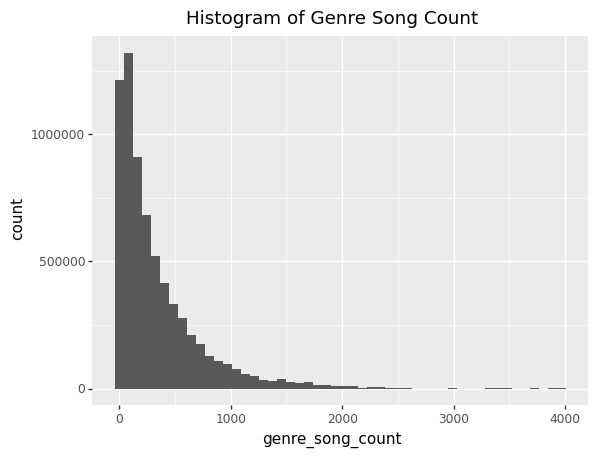

<ggplot: (8742743169277)>

In [51]:
(p9.ggplot(data=final_train_df,
             mapping=p9.aes(x="genre_song_count")) +
    p9.geom_histogram(bins=50) +
    p9.labs(title="Histogram of Genre Song Count")
)

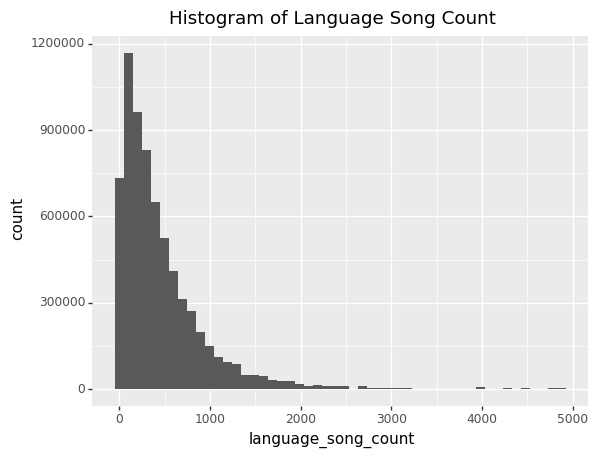

<ggplot: (8742743134977)>

In [53]:
(p9.ggplot(data=final_train_df,
             mapping=p9.aes(x="language_song_count")) +
    p9.geom_histogram(bins=50) +
    p9.labs(title="Histogram of Language Song Count")
)

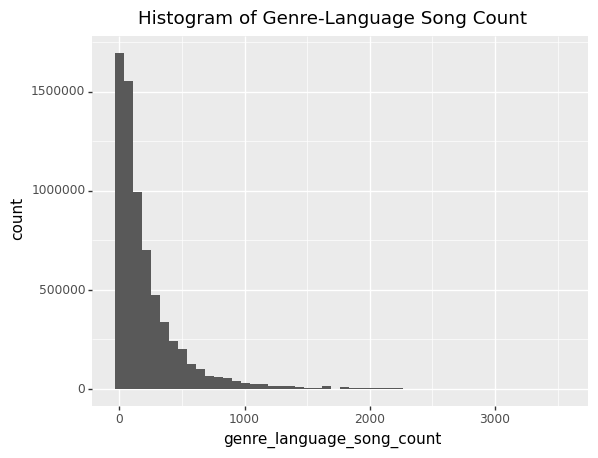

<ggplot: (8742789041917)>

In [52]:
(p9.ggplot(data=final_train_df,
           mapping=p9.aes(x="genre_language_song_count")) +
 p9.geom_histogram(bins=50) +
 p9.labs(title="Histogram of Genre-Language Song Count"))

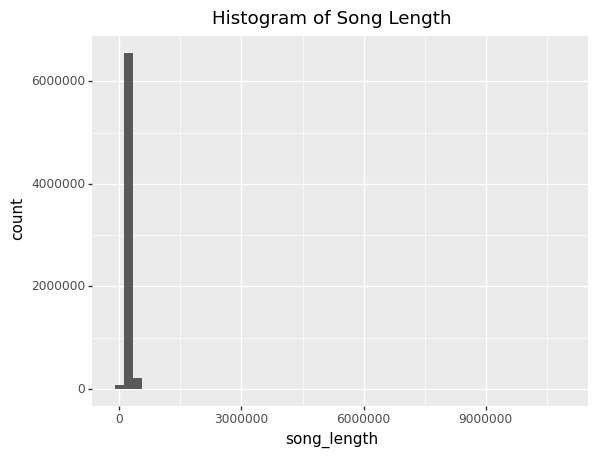

<ggplot: (8742743162621)>

In [57]:
(p9.ggplot(data=final_train_df,
             mapping=p9.aes(x="song_length")) +
    p9.geom_histogram(bins=50) +
    p9.labs(title="Histogram of Song Length")
)

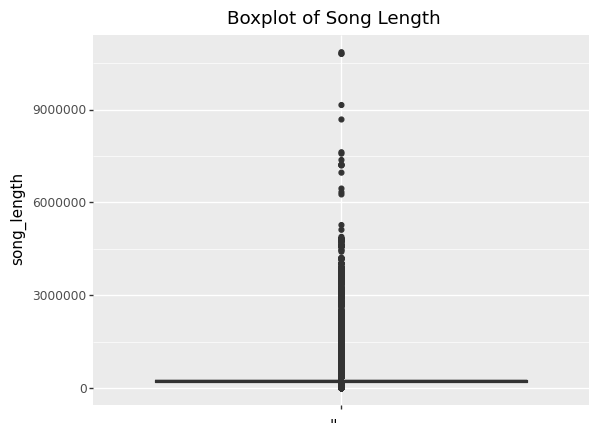

<ggplot: (8742787986953)>

In [58]:
(p9.ggplot(data=final_train_df,
             mapping=p9.aes(x="''", y="song_length")) +
    p9.geom_boxplot() +
    p9.labs(title="Boxplot of Song Length")
)

All of the features above have super skewed distributions. It would probably be beneficial to log transform the features and then standardize them.

### Yeo-Johnson transformation and dummify `source_*` columns

Because of the extreme skew, we will try Yeo-Johnson transformations for the non-percentage columns. We will also convert the `source_*` columns to dummy variables.

In [62]:
non_percent_quant_cols = ["genre_song_count", "language_song_count", "genre_language_song_count", "song_length"]
source_cols = ['source_system_tab', 'source_screen_name','source_type']

In [63]:
# Fit power transform and normalize
ct = ColumnTransformer(
    [("power_transform", PowerTransformer(method="yeo-johnson"), non_percent_quant_cols)],
    remainder="passthrough"
)
ct.set_output(transform="pandas")

ct.fit(final_train_df)

for i,col in enumerate(non_percent_quant_cols):
    lmbda = ct.named_transformers_["power_transform"].lambdas_[i]
    print(f"`{col}` Yeo-Johnson Lambda: {round(lmbda,4)}")

`genre_song_count` Yeo-Johnson Lambda: 0.192
`language_song_count` Yeo-Johnson Lambda: 0.2393
`genre_language_song_count` Yeo-Johnson Lambda: 0.1549
`song_length` Yeo-Johnson Lambda: 0.3129


All lambda values are around 0.25 and could possible be transformed well with 0.25, but we will use the values returned.

In [64]:
# Transform non-percent quantitative data
transformed_final_train_df = ct.transform(final_train_df)

# Column transformer prepends the name of the transformation to the new column
# Below fixes the columns names
transformed_cols = transformed_final_train_df.columns
for tranfomation in ct.named_transformers_.keys():
    transformed_cols = [x.replace(tranfomation+"__","") for x in transformed_cols]

transformed_final_train_df.columns = columns=transformed_cols
transformed_final_train_df = transformed_final_train_df[final_train_df.columns]

# One hot encoding for `souce_*` columns
transformed_final_train_df = pd.get_dummies(
    transformed_final_train_df,columns=source_cols, drop_first=True
)
transformed_final_train_df.head()

target   
msno                                         song_id                                                
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=       1  \
Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8= bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=       1   
                                             JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=       1   
                                             2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=       1   
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= 3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=       1   

                                                                                           genre_song_count   
msno                                         song_id                                                          
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=          0.283221  \
Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8= bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=         -0.536145   
                                             JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=         -0.536145   
                                             2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=         -2.151277   
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= 3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=         -0.762514   

                                                                                           genre_listened_again_percent   
msno                                         song_id                                                                      
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=                      0.544944  \
Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8= bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=                      0.795918   
                                             JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=                      0.795918   
                                             2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=                      1.000000   
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= 3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=                      0.564103   

                                                                                           genre_percent   
msno                                         song_id                                                       
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=       0.032966  \
Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8= bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=       0.077739   
                                             JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=       0.077739   
                                             2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=       0.001767   
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= 3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=       0.007312   

                                                                                           language_song_count   
msno                                         song_id                                                             
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=             3.348347  \
Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8= bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=            -0.391280   
                                             JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=            -0.391280   
                                             2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=            -1.803956   
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= 3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=             3.348347   

                                                                                           language_listened_again_percent   
msno                                         song_id         

#### Transformed histograms

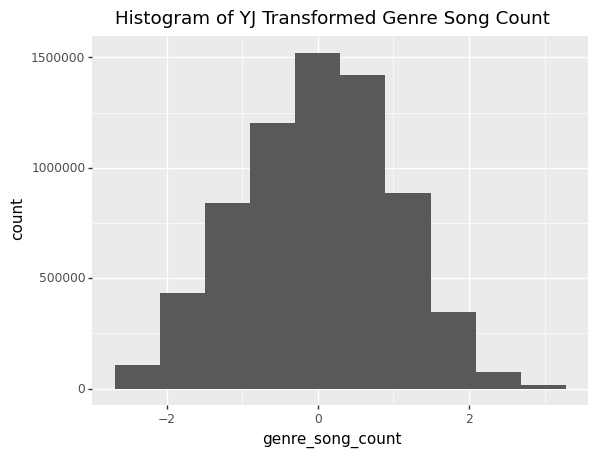

<ggplot: (8732722100921)>

In [102]:
(p9.ggplot(data=transformed_final_train_df,
             mapping=p9.aes(x="genre_song_count")) +
    p9.geom_histogram(bins=10) +
    p9.labs(title="Histogram of YJ Transformed Genre Song Count")
)

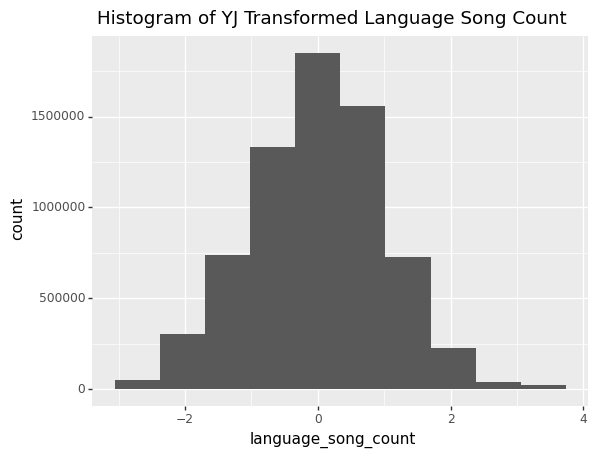

<ggplot: (8732722460097)>

In [103]:
(p9.ggplot(data=transformed_final_train_df,
             mapping=p9.aes(x="language_song_count")) +
    p9.geom_histogram(bins=10) +
    p9.labs(title="Histogram of YJ Transformed Language Song Count")
)

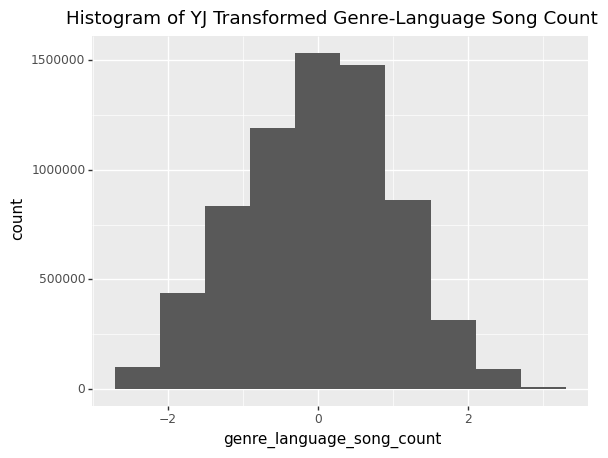

<ggplot: (8732722442505)>

In [105]:
(p9.ggplot(data=transformed_final_train_df,
           mapping=p9.aes(x="genre_language_song_count")) +
 p9.geom_histogram(bins=10) +
 p9.labs(title="Histogram of YJ Transformed Genre-Language Song Count"))

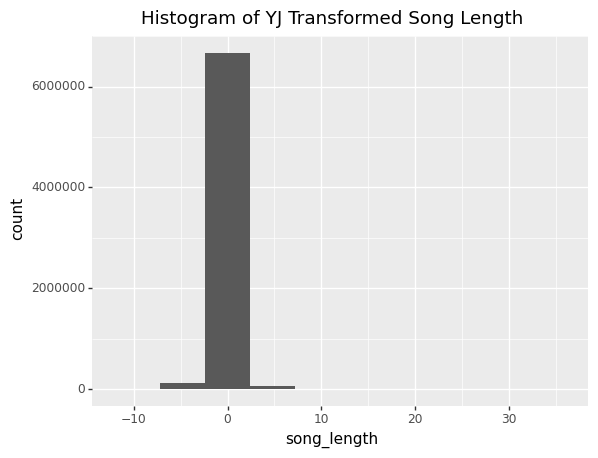

<ggplot: (8733110221417)>

In [106]:
(p9.ggplot(data=transformed_final_train_df,
           mapping=p9.aes(x="song_length")) +
 p9.geom_histogram(bins=10) +
 p9.labs(title="Histogram of YJ Transformed Song Length"))

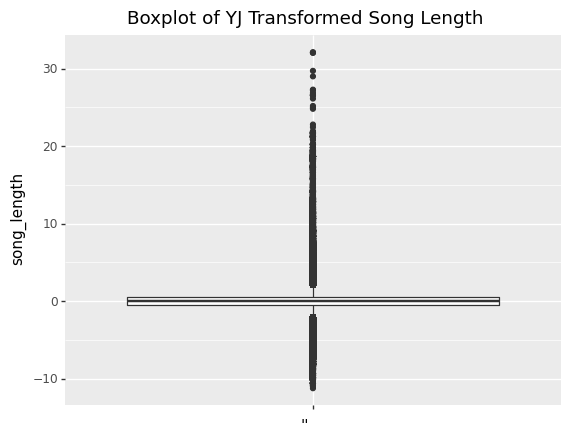

<ggplot: (8732723884773)>

In [107]:
(p9.ggplot(data=transformed_final_train_df,
             mapping=p9.aes(x="''", y="song_length")) +
    p9.geom_boxplot() +
    p9.labs(title="Boxplot of YJ Transformed Song Length")
)

# Nested Cross Validation

In this section we will use nested cross validation to compare a couple of models.

In [1]:
from os import cpu_count
import time

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import xgboost as xgb

SEED = 420

In [2]:
transformed_final_train_df = pd.read_parquet("data/transformed_final_train_df.parquet")

In [3]:
x_train = transformed_final_train_df.drop("target", axis=1)
y_train = transformed_final_train_df["target"].to_numpy()

In [4]:
genre_columns = ['genre_song_count', 'genre_listened_again_percent', 'genre_percent']
language_columns = ['language_song_count', 'language_listened_again_percent', 'language_percent']
genre_language_columns = ['genre_language_song_count', 'genre_language_listened_again_percent',
                          'genre_language_percent']

## Nested CV Parameters

In [5]:
# Created nested_cv_scores
nested_cv_scores = {}

# Choose cross-validation techniques for the inner and outer loops,
# independently of the dataset.
inner_cv = KFold(n_splits=6, shuffle=True, random_state=SEED)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

inner_cv_params = {"scoring":"neg_log_loss",
                   "cv":inner_cv,
                   "n_jobs":6,
                   "verbose":0}

outer_cv_params = {"y":y_train,
                    "cv":outer_cv,
                    "scoring":"accuracy",
                    "n_jobs":5,
                    "verbose":2}

## Logistic Regression with Genre and Language Columns

In [9]:
Cs=1/np.array([0.1,1,10,100])

# Nested CV with parameter optimization
logistic_reg = LogisticRegressionCV(Cs=Cs,
                                    solver="liblinear",
                                    penalty="l2",
                                    random_state=SEED,
                                    **inner_cv_params)
# Outer CV
nested_cv_scores["lr_both_genre_language"] = \
    cross_val_score(logistic_reg,
                    X=x_train.drop(genre_language_columns, axis=1),
                    **outer_cv_params)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 10.8min remaining: 16.2min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 10.9min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 10.9min finished


## Logistic Regression with Genre-Language Combinations

In [10]:
Cs=1/np.array([0.1,1,10,100])

# Nested CV with parameter optimization
logistic_reg = LogisticRegressionCV(Cs=Cs,
                                    solver="liblinear",
                                    penalty="l2",
                                    random_state=SEED,
                                    **inner_cv_params)
# Outer CV
nested_cv_scores["lr_genre_language_combo"] = \
cross_val_score(logistic_reg,
                X=x_train.drop(genre_columns + language_columns, axis=1),
                **outer_cv_params)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  6.9min remaining: 10.3min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.9min finished


## Logistic Regression with All Columns

In [11]:
Cs=1/np.array([0.1,1,10,100])

# Nested CV with parameter optimization
logistic_reg = LogisticRegressionCV(Cs=Cs,
                                    solver="liblinear",
                                    penalty="l2",
                                    random_state=SEED,
                                    **inner_cv_params)
# Outer CV
nested_cv_scores["lr_all_columns"] = \
cross_val_score(logistic_reg,
                X=x_train,
                **outer_cv_params)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 11.2min remaining: 16.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 11.4min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 11.4min finished


## LightGBM with Genre and Language Columns

In [ ]:
# Model params
lgbm_params = {
    'num_leaves': [31, 100],
    'min_child_samples': [30, 100],
    'reg_lambda': [1, 10, 100]
    }

# Set up model
lgbm_cl = lgb.LGBMClassifier(objective="binary",
                             learning_rate=0.05,
                             metric="binary_logloss",
                             num_threads=1,
                             force_row_wise=True,
                             subsample=0.5,
                             seed=SEED)

# Inner CV with parameter optimization
grid_cv_lgbm = GridSearchCV(lgbm_cl,
                            lgbm_params,
                            **inner_cv_params)
# Outer CV
nested_cv_scores["lgbm_both_genre_language"] = \
    cross_val_score(grid_cv_lgbm,
                    X=x_train.drop(genre_language_columns, axis=1),
                    **outer_cv_params)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM]

## LightGBM with Genre-Language Combinations

In [14]:
# Model params
lgbm_params = {
    'num_leaves': [31, 100],
    'min_child_samples': [30, 100],
    'reg_lambda': [1, 10, 100]
    }

# Set up model
lgbm_cl = lgb.LGBMClassifier(objective="binary",
                             learning_rate=0.05,
                             metric="binary_logloss",
                             num_threads=1,
                             force_row_wise=True,
                             subsample=0.5,
                             seed=SEED)

# Inner CV with parameter optimization
grid_cv_lgbm = GridSearchCV(lgbm_cl,
                            lgbm_params,
                            **inner_cv_params)
# Outer CV
nested_cv_scores["lgbm_genre_language_combo"] = \
    cross_val_score(grid_cv_lgbm,
                    X=x_train.drop(genre_columns + language_columns, axis=1),
                    **outer_cv_params)

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM]

[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 31.1min remaining: 46.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 31.4min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 31.4min finished


## LightGBM with All Columns

In [15]:
# Model params
lgbm_params = {
    'num_leaves': [31, 100],
    'min_child_samples': [30, 100],
    'reg_lambda': [1, 10, 100]
    }

# Set up model
lgbm_cl = lgb.LGBMClassifier(objective="binary",
                             learning_rate=0.05,
                             metric="binary_logloss",
                             num_threads=1,
                             force_row_wise=True,
                             subsample=0.5,
                             seed=SEED)

# Inner CV with parameter optimization
grid_cv_lgbm = GridSearchCV(lgbm_cl,
                            lgbm_params,
                            **inner_cv_params)
# Outer CV
nested_cv_scores["lgbm_all_columns"] = \
    cross_val_score(grid_cv_lgbm,
                    X=x_train,
                    **outer_cv_params)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM]

[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 37.2min remaining: 55.8min


[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[CV] END .................................................... total time=31.1min
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[CV] END .................................................... total time=37.6min
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[CV] END .................................................... total time=30.6min
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[CV] END .................................................... total time=37.6min


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 37.6min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 37.6min finished


## Compare Results

In [18]:
nested_cv_df = pd.DataFrame(
    nested_cv_scores,
    index=[f"fold_{i}" for i in range(5)]
).transpose()

nested_cv_df = pd.melt(
    nested_cv_df, var_name="fold", value_name="accuracy",ignore_index=False
).reset_index(names="model")

nested_cv_df.to_parquet("nested_cv_results.parquet")

nested_cv_df.head()

,model,fold,accuracy
0,lr_both_genre_language,fold_0,0.707453
1,lr_genre_language_combo,fold_0,0.719228
2,lr_all_columns,fold_0,0.719629
3,lgbm_both_genre_language,fold_0,0.718156
4,lgbm_genre_language_combo,fold_0,0.725942


In [61]:
nested_cv_df[nested_cv_df.model=="lgbm_genre_language_combo"].accuracy.median()

0.7250558436276195

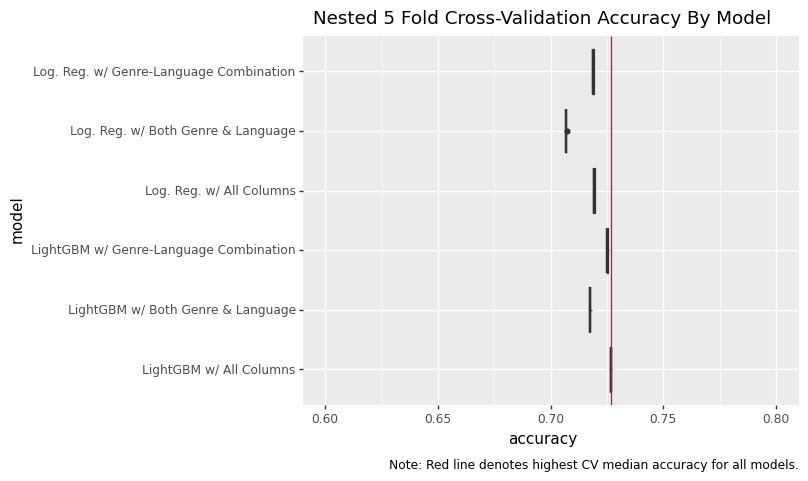

<ggplot: (8745444638005)>

In [74]:
model_names = {"lgbm_genre_language_combo":"LightGBM w/ Genre-Language Combination",
               "lgbm_both_genre_language":"LightGBM w/ Both Genre & Language",
               "lgbm_all_columns": "LightGBM w/ All Columns",
               "lr_both_genre_language":"Log. Reg. w/ Both Genre & Language",
               "lr_genre_language_combo":"Log. Reg. w/ Genre-Language Combination",
               "lr_all_columns":"Log. Reg. w/ All Columns"}

(p9.ggplot(data=nested_cv_df.replace(model_names),
          mapping=p9.aes(x="model",y="accuracy")) +
 p9.geom_boxplot() +
 p9.geom_hline(
     p9.aes(yintercept=nested_cv_df[
         nested_cv_df.model=="lgbm_all_columns"
     ].accuracy.median()), color="red"
 ) +
 p9.ylim(0.6,0.8) +
 p9.coord_flip() + 
 p9.labs(title="Nested 5 Fold Cross-Validation Accuracy By Model",
        caption="Note: Red line denotes highest CV median accuracy for all models.")
)

Based on the accuracy, LightGBM with all columns is the best performing model. However, LightGBM with only the genre-langauge combination has approximately the same accuracy, with fewer features. I prefer a simpler model, so I will use that as the final model. Below, the difference between the two LightGBM models is shown in more detail. In both models, using all columns resulted in approximately the same accuracy as using the genre-language combination. It is also interesting that there isn't much a performance increase in the much more complex LightGBM model. It's very possible that this is because the hyperparameters are not optimally tune. This may suggest that there doesn't seem to be much non-linearity in the dataset.

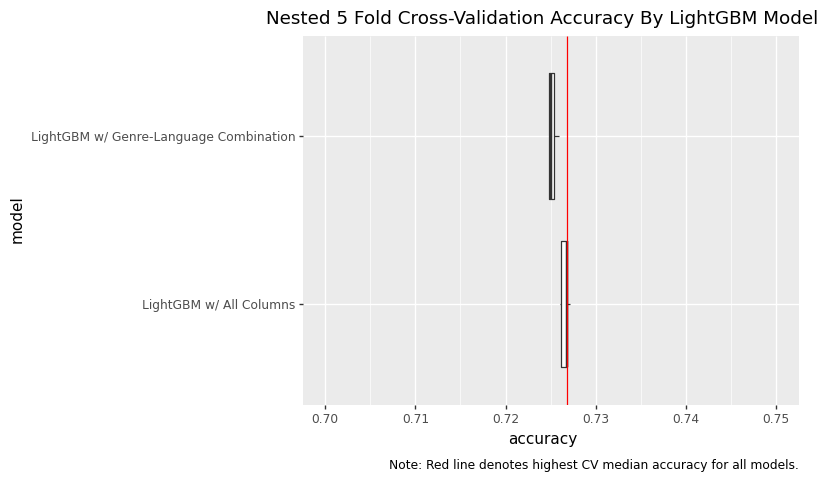

<ggplot: (8745444707613)>

In [75]:
(p9.ggplot(data=nested_cv_df[
    (nested_cv_df.model=="lgbm_all_columns") | 
    (nested_cv_df.model=="lgbm_genre_language_combo")].replace(model_names),
          mapping=p9.aes(x="model",y="accuracy")) +
 p9.geom_boxplot() +
 p9.geom_hline(
     p9.aes(yintercept=nested_cv_df[
         nested_cv_df.model=="lgbm_all_columns"
     ].accuracy.median()), color="red"
 ) +
 p9.ylim(0.7,0.75) +
 p9.coord_flip() +
 p9.labs(title="Nested 5 Fold Cross-Validation Accuracy By LightGBM Model",
        caption="Note: Red line denotes highest CV median accuracy for all models.")
)

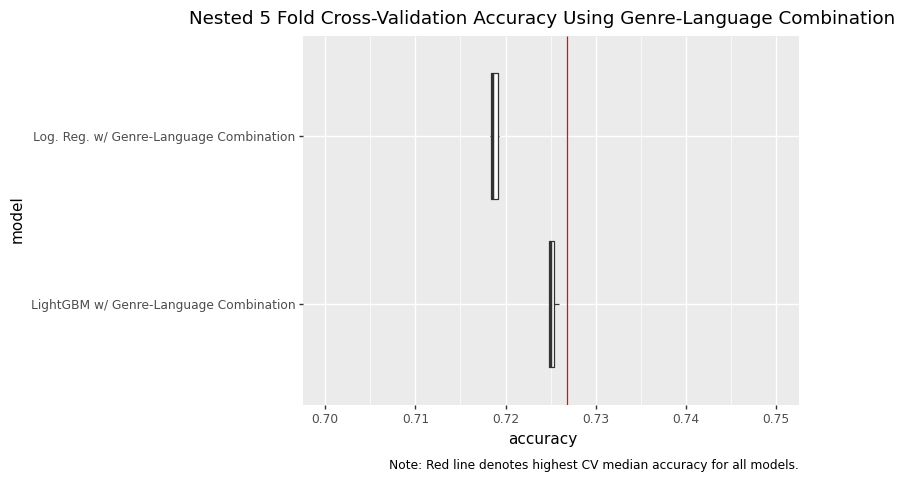

<ggplot: (8745444631065)>

In [73]:
(p9.ggplot(data=nested_cv_df[
    (nested_cv_df.model=="lr_genre_language_combo") | 
    (nested_cv_df.model=="lgbm_genre_language_combo")].replace(model_names),
          mapping=p9.aes(x="model",y="accuracy")) +
 p9.geom_boxplot() +
 p9.geom_hline(
     p9.aes(yintercept=nested_cv_df[
         nested_cv_df.model=="lgbm_all_columns"
     ].accuracy.median()), color="red"
 ) +
 p9.ylim(0.7,0.75) +
 p9.coord_flip() +
 p9.labs(title="Nested 5 Fold Cross-Validation Accuracy Using Genre-Language Combination",
        caption="Note: Red line denotes highest CV median accuracy for all models.")
)

# Re-train Logistic Regression

In [10]:
Cs=1/np.array([0.1,1,10,100])

# Nested CV with parameter optimization
logistic_reg = LogisticRegressionCV(Cs=Cs,
                                    solver="liblinear",
                                    penalty="l2",
                                    scoring="neg_log_loss",
                                    cv=inner_cv,
                                    random_state=SEED,
                                    verbose=0
                                   )
logistic_reg.fit(
    X=x_train.drop(genre_columns + language_columns, axis=1),
    y=y_train
)

LogisticRegressionCV(Cs=array([10.  ,  1.  ,  0.1 ,  0.01]),
                     cv=KFold(n_splits=6, random_state=420, shuffle=True),
                     random_state=420, scoring='neg_log_loss',
                     solver='liblinear')

## Best Parameters

In [15]:
print(f"Best Lambda: {1/logistic_reg.C_[0]}")

Best Lambda: 10.0


## Save Model

In [16]:
# Save CV models and results
joblib.dump(logistic_reg, 'models/logistic_reg_cv.pkl')

['models/logistic_reg_cv.pkl']

### Check loaded models

In [18]:
# Save CV models and results
joblib.load('models/logistic_reg_cv.pkl').scores_

{1: array([[-0.53430204, -0.53430201, -0.53430194, -0.53430426],
        [-0.53475983, -0.53475979, -0.53475957, -0.53476214],
        [-0.53548278, -0.5354824 , -0.53548183, -0.53547998],
        [-0.53510707, -0.53510643, -0.53510643, -0.53510719],
        [-0.53513463, -0.53513489, -0.5351347 , -0.53513681],
        [-0.53446485, -0.53446515, -0.53446582, -0.534472  ]])}

# Re-train LightGBM

In [21]:
# Model params
lgbm_params = {
    'num_leaves': [31, 100],
    'min_data_in_leaf': [30, 100],
    'lambda_l2': [1, 10, 100]
    }

# Set up model
lgbm_cl = lgb.LGBMClassifier(objective="binary",
                             learning_rate=0.05,
                             metric="binary_logloss",
                             subsample=0.5,
                             num_threads=1,
                             force_row_wise=True,
                             seed=SEED,
                             verbosity=0)

# Inner CV with parameter optimization
final_grid_cv_lgbm = GridSearchCV(lgbm_cl,
                                  lgbm_params,
                                  scoring=["neg_log_loss","accuracy"],
                                  refit="neg_log_loss",
                                  return_train_score=True,
                                  n_jobs=30,
                                  cv=inner_cv,
                                  verbose=1
                                 )

final_grid_cv_lgbm.fit(X=x_train.drop(genre_columns + language_columns, axis=1),
                y=y_train)

Fitting 6 folds for each of 12 candidates, totalling 72 fits
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_

GridSearchCV(cv=KFold(n_splits=6, random_state=420, shuffle=True),
             estimator=LGBMClassifier(force_row_wise=True, learning_rate=0.05,
                                      metric='binary_logloss', num_threads=1,
                                      objective='binary', seed=420,
                                      subsample=0.5, verbosity=0),
             n_jobs=30,
             param_grid={'lambda_l2': [1, 10, 100],
                         'min_data_in_leaf': [30, 100],
                         'num_leaves': [31, 100]},
             refit='neg_log_loss', return_train_score=True,
             scoring=['neg_log_loss', 'accuracy'], verbose=1)

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda

## Best Parameters

In [24]:
final_grid_cv_lgbm.best_params_

{'lambda_l2': 1, 'min_data_in_leaf': 100, 'num_leaves': 100}

## Save Model

In [53]:
# Save CV models and results
joblib.dump(final_grid_cv_lgbm, 'models/gridcv_final_lightGBM.pkl')

['models/gridcv_final_lightGBM.pkl']

In [54]:
# Save only the final booser model
final_grid_cv_lgbm.best_estimator_.booster_.save_model('models/final_lightGBM.txt')

### Check loaded models

In [56]:
final_grid_cv_lgbm.best_estimator_.predict_proba(
    x_train.drop(genre_columns + language_columns, axis=1).iloc[:3]
)

array([[0.47076458, 0.52923542],
       [0.11081971, 0.88918029],
       [0.11082147, 0.88917853]])

In [19]:
# CV Loaded Model
joblib.load("models/gridcv_final_lightGBM.pkl").predict_proba(
    x_train.drop(genre_columns + language_columns, axis=1).iloc[:3]
)

array([[0.47076458, 0.52923542],
       [0.11081971, 0.88918029],
       [0.11082147, 0.88917853]])

In [20]:
# LGBM Booster Loaded Model
lgb.Booster(model_file="models/final_lightGBM.txt").predict(
    x_train.drop(genre_columns + language_columns, axis=1).iloc[:3]
)

array([0.52923542, 0.88918029, 0.88917853])

# Top Features for Models

## LightGBM Features

In [37]:
# Feature Importance
lightGBM_features = pd.DataFrame({
    "feature_name":final_grid_cv_lgbm.best_estimator_.feature_name_,
    "importance":final_grid_cv_lgbm.best_estimator_.feature_importances_
}).sort_values("importance", ascending=False).set_index("feature_name")

lightGBM_features.head(10)

,importance
feature_name,
song_length,2555
genre_language_listened_again_percent,1516
genre_language_song_count,1297
genre_language_percent,1034
source_type_online-playlist,442
source_type_local-playlist,438
source_screen_name_Local_playlist_more,352
source_screen_name_Search,330
source_screen_name_Discover_Chart,262


## Logistic Regression Features

In [53]:
# Feature Importance
log_reg_features = pd.DataFrame({
    "feature_name":logistic_reg.feature_names_in_,
    "coef":logistic_reg.coef_[0]
}).sort_values("coef", ascending=False).set_index("feature_name")

log_reg_features.head(10)

,coef
feature_name,
genre_language_listened_again_percent,4.846594
source_type_local-playlist,0.656377
source_screen_name_My library_Search,0.445814
source_screen_name_Discover Chart,0.413020
source_type_local-library,0.407509
source_type_my-daily-playlist,0.407294
source_type_artist,0.283245
source_screen_name_Search,0.244373
source_screen_name_Local playlist more,0.217854


In [54]:
log_reg_features.tail(10)

,coef
feature_name,
source_screen_name_Radio,-0.078568
source_system_tab_my library,-0.079928
source_screen_name_Others profile more,-0.108280
source_screen_name_Unknown,-0.115853
genre_language_percent,-0.137020
source_type_song-based-playlist,-0.158360
source_screen_name_Search Trends,-0.183342
source_screen_name_Search Home,-0.246676
source_system_tab_settings,-0.349915


After reviewing the top features, it seems that XGBoost may be overfit, so we will stick with the logistic regression.

## Test Set Preditions (Not Working Yet)

20% of test data is missing so I would need to implement imputation methods. There are also categories for source type that do no exist in the training dataset. The models should be retrained with a missing dummy variable for all source types so new data can be predicted on. A method would also need to be generated for new users who do not have any historical listening data.

### Load data

In [ ]:
test_df.shape

In [2]:
# Load data
test_df = pd.read_csv("data/test.csv")
clean_song_df = pd.read_parquet("data/clean_songs.paquet")
user_genre_language_df = pd.read_parquet("data/user_genre_language_combinations.parquet")

In [3]:
source_cols = ['source_system_tab', 'source_screen_name','source_type']

# Remove observations with missing data in `source_*` columns
clean_test_df = test_df.dropna(subset=source_cols)
print(clean_test_df.shape[0] / test_df.shape[0])
clean_test_df.head()

0.935792927850938


,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio
5,5,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,NV3nhEcMqsawwvSNTUAt9IVAexHLOm0lDfrHyEfN5B0=,radio,Radio,radio


In [4]:
song_genre = clean_song_df.set_index("song_id").genre_ids.str.split("|").explode().reset_index()

# Doesn't include genre
clean_merged_test_df = clean_test_df.merge(
    clean_song_df[["song_id","song_length","language"]], on="song_id"
)
# Includes unnest genres -> duplicate observations for a song with multiple genres
clean_merged_genre_test_df = clean_merged_test_df.merge(song_genre, on="song_id")
clean_merged_genre_test_df.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,language,genre_ids
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,224130,3.0,458
1,2954,mp5bRgC7VAhEpWlAiOn4jG8CD9FJZt7725f93t5i99M=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Search,song,224130,3.0,458
2,14420,NSBR1BrOO3XDapGQCMi19nRidHD4qzoEXbGGnBap/e0=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-playlist,224130,3.0,458
3,17473,kvRxHi514EY2/4FzahC/vBf/Zn13/3ZwXweeepjewzk=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-playlist,224130,3.0,458
4,32738,Qh0RP1Refm1D6eV5PjusX+agjnNczGUR8eeWBGj3UvU=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-playlist,224130,3.0,458


### Create genre-language features

In [5]:
# Merge language features into test set
genre_language_scores_df = clean_merged_genre_test_df.set_index(
    ["msno","genre_ids","language"]
).merge(user_genre_language_df, left_index=True, right_index=True)

# Reset index, select relevant features and rename them
genre_language_scores_df = genre_language_scores_df.reset_index()[
    ["msno","genre_ids","language","song_id","total_song_count",
     "proportion_listened_again","genre_language_percent"]
].rename(columns={"total_song_count": "genre_language_song_count",
                 "proportion_listened_again": "genre_language_listened_again_percent"})

# Group by user, song_id then select the genre-language with the most number of songs
genre_language_scores_df = genre_language_scores_df.set_index(
    ["msno", "song_id", "genre_ids", "language"]
).sort_values("genre_language_song_count", ascending=False)\
.groupby(["msno", "song_id"]).first()

genre_language_scores_df.head()

genre_language_song_count   
msno                                         song_id                                                                   
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +QIN3k3cgS0F4Js3zKfkBuYeKD4wJYOO4/skMiKERIs=                         20  \
                                             /b9PyHcmn9w6clos/a7MA0hgBnYuhaU5GArheP5Ga28=                          1   
                                             0377gdz/4vY1VvrWvU7qdb5kc63Byj9N9a87tgMK7C4=                         20   
                                             0Nm7NwzUtBQAXXeUPi/tWAp9g3E0KanBezUOwNuwYt0=                          1   
                                             0pKwIZnrNIIhf0CrIl5aXVZ1rVM9TovcGWLSgXzo7Pc=                         20   

                                                                                           genre_language_listened_again_percent   
msno                                         song_id                                                                               
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +QIN3k3cgS0F4Js3zKfkBuYeKD4wJYOO4/skMiKERIs=                               0.666667  \
                                             /b9PyHcmn9w6clos/a7MA0hgBnYuhaU5GArheP5Ga28=                               0.000000   
                                             0377gdz/4vY1VvrWvU7qdb5kc63Byj9N9a87tgMK7C4=                               0.666667   
                                             0Nm7NwzUtBQAXXeUPi/tWAp9g3E0KanBezUOwNuwYt0=                               0.000000   
                                             0pKwIZnrNIIhf0CrIl5aXVZ1rVM9TovcGWLSgXzo7Pc=                               0.666667   

                                                                                           genre_language_percent  
msno                                         song_id                                                               
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +QIN3k3cgS0F4Js3zKfkBuYeKD4wJYOO4/skMiKERIs=                0.031104  
                                             /b9PyHcmn9w6clos/a7MA0hgBnYuhaU5GArheP5Ga28=                0.001555  
                                             0377gdz/4vY1VvrWvU7qdb5kc63Byj9N9a87tgMK7C4=                0.031104  
                                             0Nm7NwzUtBQAXXeUPi/tWAp9g3E0KanBezUOwNuwYt0=                0.001555  
                                             0pKwIZnrNIIhf0CrIl5aXVZ1rVM9TovcGWLSgXzo7Pc=                0.031104

### Merge into final dataframe

In [6]:
final_test_df = clean_test_df.set_index(["msno","song_id"])

# Inner join which will remove observations without genre info (~1% of total obs)
# Join genre-language score
final_test_df = final_test_df.merge(genre_language_scores_df, left_index=True, right_index=True)
# Join song length
final_test_df = final_test_df.merge(clean_merged_genre_test_df.set_index(["msno","song_id"]).song_length,
                                      left_index=True, right_index=True)

final_test_df.head()

id   
msno                                         song_id                                                 
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +QIN3k3cgS0F4Js3zKfkBuYeKD4wJYOO4/skMiKERIs=  2075308  \
                                             /b9PyHcmn9w6clos/a7MA0hgBnYuhaU5GArheP5Ga28=   375243   
                                             0377gdz/4vY1VvrWvU7qdb5kc63Byj9N9a87tgMK7C4=  2077737   
                                             0Nm7NwzUtBQAXXeUPi/tWAp9g3E0KanBezUOwNuwYt0=   421736   
                                             0pKwIZnrNIIhf0CrIl5aXVZ1rVM9TovcGWLSgXzo7Pc=  2074107   

                                                                                          source_system_tab   
msno                                         song_id                                                          
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +QIN3k3cgS0F4Js3zKfkBuYeKD4wJYOO4/skMiKERIs=        my library  \
                                             /b9PyHcmn9w6clos/a7MA0hgBnYuhaU5GArheP5Ga28=        my library   
                                             0377gdz/4vY1VvrWvU7qdb5kc63Byj9N9a87tgMK7C4=        my library   
                                             0Nm7NwzUtBQAXXeUPi/tWAp9g3E0KanBezUOwNuwYt0=        my library   
                                             0pKwIZnrNIIhf0CrIl5aXVZ1rVM9TovcGWLSgXzo7Pc=        my library   

                                                                                            source_screen_name   
msno                                         song_id                                                             
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +QIN3k3cgS0F4Js3zKfkBuYeKD4wJYOO4/skMiKERIs=  Local playlist more  \
                                             /b9PyHcmn9w6clos/a7MA0hgBnYuhaU5GArheP5Ga28=  Local playlist more   
                                             0377gdz/4vY1VvrWvU7qdb5kc63Byj9N9a87tgMK7C4=  Local playlist more   
                                             0Nm7NwzUtBQAXXeUPi/tWAp9g3E0KanBezUOwNuwYt0=  Local playlist more   
                                             0pKwIZnrNIIhf0CrIl5aXVZ1rVM9TovcGWLSgXzo7Pc=  Local playlist more   

                                                                                              source_type   
msno                                         song_id                                                        
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +QIN3k3cgS0F4Js3zKfkBuYeKD4wJYOO4/skMiKERIs=  local-playlist  \
                                             /b9PyHcmn9w6clos/a7MA0hgBnYuhaU5GArheP5Ga28=  local-playlist   
                                             0377gdz/4vY1VvrWvU7qdb5kc63Byj9N9a87tgMK7C4=  local-playlist   
                                             0Nm7NwzUtBQAXXeUPi/tWAp9g3E0KanBezUOwNuwYt0=  local-playlist   
                                             0pKwIZnrNIIhf0CrIl5aXVZ1rVM9TovcGWLSgXzo7Pc=  local-playlist   

                                                                                           genre_language_song_count   
msno                                         song_id                                                                   
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +QIN3k3cgS0F4Js3zKfkBuYeKD4wJYOO4/skMiKERIs=                         20  \
                                             /b9PyHcmn9w6clos/a7MA0hgBnYuhaU5GArheP5Ga28=                          1   
                                             0377gdz/4vY1VvrWvU7qdb5kc63Byj9N9a87tgMK7C4=                         20   
                                             0Nm7NwzUtBQAXXeUPi/tWAp9g3E0KanBezUOwNuwYt0=                          1   
                                             0pKwIZnrNIIhf0CrIl5aXVZ1rVM9TovcGWLSgXzo7Pc=                         20   

                                                                                           genre_language_listened_again_percent   
msno                                         song_id               

### Column Transformations

#### Create transformations for only genre-langauge

*Skip if final transformer is already created in models folder.*

In [34]:
final_train_df = pd.read_parquet("data/final_train.parquet")

non_percent_quant_cols = ["genre_language_song_count", "song_length"]
source_cols = ['source_system_tab', 'source_screen_name','source_type']

genre_columns = ['genre_song_count', 'genre_listened_again_percent', 'genre_percent']
language_columns = ['language_song_count', 'language_listened_again_percent', 'language_percent']
genre_language_columns = ['genre_language_song_count', 'genre_language_listened_again_percent',
                          'genre_language_percent']

final_train_df = final_train_df.drop(genre_columns + language_columns + ["target"], axis=1)

# Fit power transform and normalize
column_transformer = ColumnTransformer(
    [("power_transform", PowerTransformer(method="yeo-johnson"), non_percent_quant_cols)],
    remainder="passthrough"
)
column_transformer.set_output(transform="pandas")

column_transformer.fit(final_train_df)

joblib.dump(column_transformer, "models/column_transformations.pkl")

['models/column_transformations.pkl']

#### Transform test data

In [35]:
column_transformer = joblib.load("models/column_transformations.pkl")

non_percent_quant_cols = ["genre_language_song_count", "song_length"]
source_cols = ['source_system_tab', 'source_screen_name','source_type']

In [36]:
# Transform non-percent quantitative data
transformed_final_test_df = column_transformer.transform(final_test_df)

# Column transformer prepends the name of the transformation to the new column
# Below fixes the columns names
transformed_cols = transformed_final_test_df.columns
for tranfomation in column_transformer.named_transformers_.keys():
    transformed_cols = [x.replace(tranfomation+"__","") for x in transformed_cols]

transformed_final_test_df.columns = columns=transformed_cols
transformed_final_test_df = transformed_final_test_df[final_train_df.columns]

# One hot encoding for `souce_*` columns
transformed_final_test_df = pd.get_dummies(
    transformed_final_test_df,columns=source_cols, drop_first=True
)

transformed_final_test_df.to_parquet("data/transformed_final_test.parquet")
transformed_final_test_df.head()

genre_language_song_count   
msno                                         song_id                                                                   
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +QIN3k3cgS0F4Js3zKfkBuYeKD4wJYOO4/skMiKERIs=                  -1.056698  \
                                             /b9PyHcmn9w6clos/a7MA0hgBnYuhaU5GArheP5Ga28=                  -2.145734   
                                             0377gdz/4vY1VvrWvU7qdb5kc63Byj9N9a87tgMK7C4=                  -1.056698   
                                             0Nm7NwzUtBQAXXeUPi/tWAp9g3E0KanBezUOwNuwYt0=                  -2.145734   
                                             0pKwIZnrNIIhf0CrIl5aXVZ1rVM9TovcGWLSgXzo7Pc=                  -1.056698   

                                                                                           genre_language_listened_again_percent   
msno                                         song_id                                                                               
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +QIN3k3cgS0F4Js3zKfkBuYeKD4wJYOO4/skMiKERIs=                               0.666667  \
                                             /b9PyHcmn9w6clos/a7MA0hgBnYuhaU5GArheP5Ga28=                               0.000000   
                                             0377gdz/4vY1VvrWvU7qdb5kc63Byj9N9a87tgMK7C4=                               0.666667   
                                             0Nm7NwzUtBQAXXeUPi/tWAp9g3E0KanBezUOwNuwYt0=                               0.000000   
                                             0pKwIZnrNIIhf0CrIl5aXVZ1rVM9TovcGWLSgXzo7Pc=                               0.666667   

                                                                                           genre_language_percent   
msno                                         song_id                                                                
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +QIN3k3cgS0F4Js3zKfkBuYeKD4wJYOO4/skMiKERIs=                0.031104  \
                                             /b9PyHcmn9w6clos/a7MA0hgBnYuhaU5GArheP5Ga28=                0.001555   
                                             0377gdz/4vY1VvrWvU7qdb5kc63Byj9N9a87tgMK7C4=                0.031104   
                                             0Nm7NwzUtBQAXXeUPi/tWAp9g3E0KanBezUOwNuwYt0=                0.001555   
                                             0pKwIZnrNIIhf0CrIl5aXVZ1rVM9TovcGWLSgXzo7Pc=                0.031104   

                                                                                           song_length   
msno                                         song_id                                                     
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +QIN3k3cgS0F4Js3zKfkBuYeKD4wJYOO4/skMiKERIs=    -1.375850  \
                                             /b9PyHcmn9w6clos/a7MA0hgBnYuhaU5GArheP5Ga28=    -0.685437   
                                             0377gdz/4vY1VvrWvU7qdb5kc63Byj9N9a87tgMK7C4=    -0.178248   
                                             0Nm7NwzUtBQAXXeUPi/tWAp9g3E0KanBezUOwNuwYt0=    -0.542441   
                                             0pKwIZnrNIIhf0CrIl5aXVZ1rVM9TovcGWLSgXzo7Pc=    -0.668465   

                                                                                           source_system_tab_explore   
msno                                         song_id                                                                   
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= +QIN3k3cgS0F4Js3zKfkBuYeKD4wJYOO4/skMiKERIs=                      False  \
                                             /b9PyHcmn9w6clos/a7MA0hgBnYuhaU5GArheP5Ga28=                      False   
                                             0377gdz/4vY1VvrWvU7qdb5kc63Byj9N9a87tgMK7C4=                      False   
                                             0Nm7NwzUtBQAXXeUPi/tWAp9g3E0KanBezUOwNuwYt0=                      False   
                                          

# Plot Predictors

## Load Data and Models

In [2]:
logistic_regression = joblib.load('models/logistic_reg_cv.pkl')
light_gbm = joblib.load("models/gridcv_final_lightGBM.pkl")

In [3]:
transformed_final_train_df = pd.read_parquet("data/transformed_final_train_df.parquet")
x_train = transformed_final_train_df.drop("target", axis=1)
y_train = transformed_final_train_df["target"].to_numpy()

## Generate Grid for Genre-Langauge % Re-Listened and Source Type

In [4]:
genre_columns = ['genre_song_count', 'genre_listened_again_percent', 'genre_percent']
language_columns = ['language_song_count', 'language_listened_again_percent', 'language_percent']
genre_language_columns = ['genre_language_song_count', 'genre_language_listened_again_percent',
                          'genre_language_percent']

x_train = x_train.drop(genre_columns+language_columns,axis=1)

In [27]:
NUM_STEPS = 100

# Get medians and modes
genre_language_grid = pd.DataFrame(
    x_train[genre_language_columns+["song_length"]].median()
).transpose().join(
    x_train.drop(genre_language_columns+["song_length"], axis=1).mode()
)

# Add genre_language_listened_again_percent sequence
genre_language_grid = pd.concat([genre_language_grid]*NUM_STEPS)
genre_language_grid[
    "genre_language_listened_again_percent"
] = np.arange(0,1,1/NUM_STEPS)

# Duplicate and add values for local-playlist, radio, local-library
genre_language_grid = pd.concat(
    [genre_language_grid]*3
)
# First radio, then local-playlist, then local-library
genre_language_grid[
    "source_type_radio"
] = ([True] * NUM_STEPS) + ([False] * (2*NUM_STEPS))
genre_language_grid[
    "source_type_local-playlist"
] = ([False] * NUM_STEPS) + ([True] * NUM_STEPS) + ([False] * NUM_STEPS)
genre_language_grid[
    "source_type_local-library"
] = ([False] * (2*NUM_STEPS)) + ([True] * NUM_STEPS)

genre_language_grid.head()

,genre_language_song_count,genre_language_listened_again_percent,genre_language_percent,song_length,source_system_tab_explore,source_system_tab_listen with,source_system_tab_my library,source_system_tab_notification,source_system_tab_radio,source_system_tab_search,...,source_type_listen-with,source_type_local-library,source_type_local-playlist,source_type_my-daily-playlist,source_type_online-playlist,source_type_radio,source_type_song,source_type_song-based-playlist,source_type_top-hits-for-artist,source_type_topic-article-playlist
0,0.054938,0.00,0.198178,0.014887,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
0,0.054938,0.01,0.198178,0.014887,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
0,0.054938,0.02,0.198178,0.014887,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
0,0.054938,0.03,0.198178,0.014887,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
0,0.054938,0.04,0.198178,0.014887,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [28]:
lr_genre_langauge_preds = pd.DataFrame(
    logistic_regression.predict_proba(genre_language_grid)
).drop(0,axis=1).rename({1:"Probability Listened Again"}, axis=1)

lr_genre_langauge_preds[
    "Genre-Language Percent Listened Again"
] = genre_language_grid.genre_language_listened_again_percent.to_list()

lr_genre_langauge_preds[
    "Source Type"
] = (["Radio"] * NUM_STEPS) + (["Local Playlist"] * NUM_STEPS) + (["Local Library"] * NUM_STEPS)

lr_genre_langauge_preds[
    "Model"
] = ["Logistic Regression"] * (3*NUM_STEPS)

lr_genre_langauge_preds.head()

,Probability Listened Again,Genre-Language Percent Listened Again,Source Type,Model
0,0.034949,0.00,Radio,Logistic Regression
1,0.036621,0.01,Radio,Logistic Regression
2,0.038369,0.02,Radio,Logistic Regression
3,0.040198,0.03,Radio,Logistic Regression
4,0.042110,0.04,Radio,Logistic Regression


In [30]:
lgb_genre_langauge_preds = pd.DataFrame(
    light_gbm.predict_proba(genre_language_grid)
).drop(0,axis=1).rename({1:"Probability Listened Again"}, axis=1)

lgb_genre_langauge_preds[
    "Genre-Language Percent Listened Again"
] = genre_language_grid.genre_language_listened_again_percent.to_list()


lgb_genre_langauge_preds[
    "Source Type"
] =  (["Radio"] * NUM_STEPS) + (["Local Playlist"] * NUM_STEPS) + (["Local Library"] * NUM_STEPS)

lgb_genre_langauge_preds[
    "Model"
] = ["LightGBM"] * (3*NUM_STEPS)

lgb_genre_langauge_preds.head()

,Probability Listened Again,Genre-Language Percent Listened Again,Source Type,Model
0,0.003361,0.00,Radio,LightGBM
1,0.035569,0.01,Radio,LightGBM
2,0.035569,0.02,Radio,LightGBM
3,0.035569,0.03,Radio,LightGBM
4,0.048316,0.04,Radio,LightGBM


In [31]:
all_genre_language_preds = pd.concat(
    [lr_genre_langauge_preds, lgb_genre_langauge_preds]
)

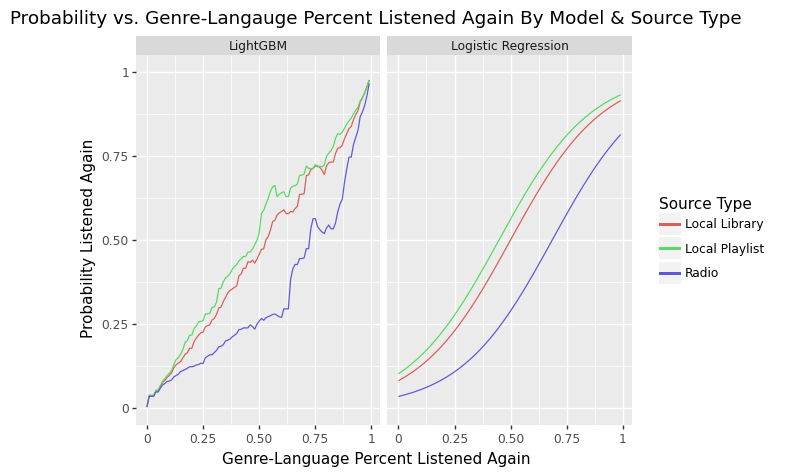

<ggplot: (8754808557313)>

In [45]:
(p9.ggplot(all_genre_language_preds,
          mapping=p9.aes(x="Genre-Language Percent Listened Again",
                         y="Probability Listened Again",
                         color="Source Type"
                        )) +
 p9.geom_line() +
 p9.labs(title="Probability vs. Genre-Langauge Percent Listened Again By Model & Source Type"
        ) +
 p9.ylim(0,1) + 
 p9.facet_wrap("Model")
)

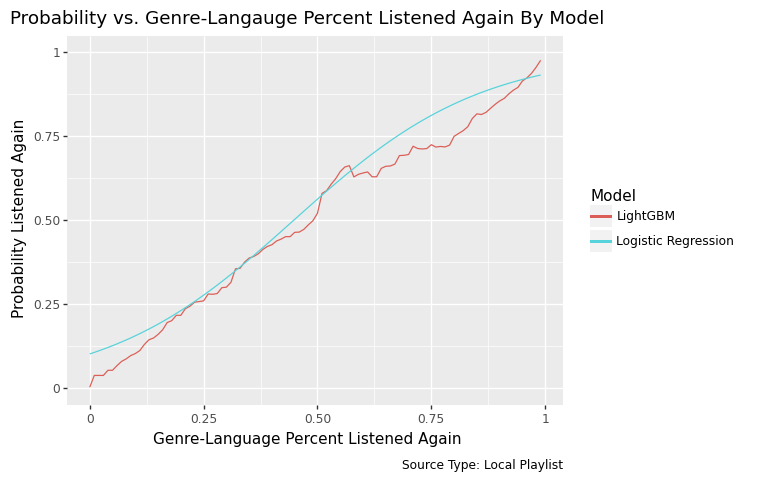

<ggplot: (8754808706929)>

In [36]:
(p9.ggplot(all_genre_language_preds[
    all_genre_language_preds["Source Type"]=="Local Playlist"
],
          mapping=p9.aes(x="Genre-Language Percent Listened Again",
                         y="Probability Listened Again",
                         color="Model"
                        )) +
 p9.geom_line() +
 p9.labs(title="Probability vs. Genre-Langauge Percent Listened Again By Model",
         caption="Source Type: Local Playlist"
        ) +
 p9.ylim(0,1)
)